# Barrido 3D: K_intra × K_inter_ratio × Delay
**Objetivo:** Mapear funciones de autocorrelación e intrinsic timescales

**Estrategia:**
- Solo guardar spikes (no voltage)
- Calcular autocorrelación on-the-fly
- Extraer timescales con 2 métodos (exponential + integrated)
- 3 trials por configuración
- Plots progresivos cada 5 batches
- Checkpointing cada 10 batches

In [1]:
# Setup
import os
import sys
from pathlib import Path

if Path.cwd().name != 'izhikevich':
    os.chdir('../..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import json
import pickle
from datetime import datetime
from tqdm.auto import tqdm
from scipy.optimize import curve_fit
from joblib import Parallel, delayed

from brian2 import *

from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import (
    spikes_to_population_rate,
    cross_correlation_analysis,
    intrinsic_timescale_analysis
)
from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="sweep_3d_autocorr",
    console_level="INFO",
    file_level="DEBUG",
    log_to_file=True
)

logger.info(f"Working directory: {Path.cwd()}")

/home/tonicoll/.local/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO     | src.two_populations.helpers.logger:setup_logger:98 - Logs guardándose en: /home/tonicoll/Projects/izhikevich/results/logs/sweep_3d_autocorr_20251215_115936.log
INFO     | __main__:<module>:37 - Working directory: /home/tonicoll/Projects/izhikevich


In [2]:
# =============================================================================
# FUNCIONES DE CÁLCULO ON-THE-FLY
# =============================================================================

def compute_autocorr_and_timescales(spike_times, spike_neurons, N_neurons, 
                                     warmup_ms, T_total, analysis_dt, max_lag_ms):
    """Calcula autocorrelación y tau_int."""
    
    # Population rate
    time, rate = spikes_to_population_rate(
        type('obj', (), {'t': spike_times*ms, 'i': spike_neurons})(),
        N_neurons,
        smooth_window=1,
        analysis_dt=analysis_dt,
        T_total=T_total
    )
    
    # Filtrar warmup
    mask = time >= warmup_ms
    time_filt = time[mask]
    rate_filt = rate[mask]
    
    mean_rate = np.mean(rate_filt)
    
    if len(rate_filt) < 10:
        return None
    
    # Autocorrelación
    ac_result = cross_correlation_analysis(
        rate_filt, rate_filt,
        max_lag_ms=max_lag_ms,
        dt=analysis_dt
    )
    
    # Timescales (tau_int es robusto)
    ts_result = intrinsic_timescale_analysis(
        rate_filt,
        max_lag_ms=max_lag_ms,
        dt=analysis_dt
    )
    
    return {
        'tau_int': ts_result['tau_int'],
        'ac_peak': ac_result['peak_value'],
        'ac_lags': ac_result['lags'],
        'ac_corr': ac_result['correlation'],
        'mean_rate': mean_rate,
        'quality': ts_result['quality']
    }

def plot_ac_diagnostic(h5_file, sim_key, output_dir):
    """Plot detallado de AC con ambos métodos"""
    with h5py.File(h5_file, 'r') as f:
        grp = f[sim_key]
        
        # Config info
        k_intra = grp.attrs['k_intra']
        k_inter_ratio = grp.attrs['k_inter_ratio']
        delay_ms = grp.attrs['delay_ms']
        
        # Cargar spikes
        spike_times = grp['spikes_A_times'][:]
        spike_neurons = grp['spikes_A_neurons'][:]
        
        # Cargar métricas guardadas
        # tau_exp_saved = grp['metrics/A'].attrs['tau_exp']
        tau_int_saved = grp['metrics/A'].attrs['tau_int']
        mean_rate_saved = grp['metrics/A'].attrs['mean_rate']
    
    # Recalcular population rate
    time, rate = spikes_to_population_rate(
        type('obj', (), {'t': spike_times*ms, 'i': spike_neurons})(),
        1000, smooth_window=1, analysis_dt=1.0, T_total=2500
    )
    
    # Filtrar warmup
    mask = time >= 500
    time_filt, rate_filt = time[mask], rate[mask]
    
    # Recalcular AC y timescales
    ac_result = cross_correlation_analysis(rate_filt, rate_filt, max_lag_ms=500, dt=1.0)
    ts_result = intrinsic_timescale_analysis(rate_filt, max_lag_ms=500, dt=1.0)
    
    lags = ac_result['lags']
    corr = ac_result['correlation']
    corr_norm = corr / np.max(np.abs(corr))
    
    pos_mask = lags >= 0
    lags_pos, corr_pos = lags[pos_mask], corr_norm[pos_mask]
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Population rate
    axes[0,0].plot(time_filt, rate_filt, 'k-', linewidth=1)
    axes[0,0].set_xlabel('Time (ms)')
    axes[0,0].set_ylabel('Rate (Hz)')
    axes[0,0].set_title(f'Pop Rate (mean={mean_rate_saved:.1f}Hz)')
    axes[0,0].grid(alpha=0.3)
    
    # 2. AC completa
    axes[0,1].plot(lags, corr_norm, 'k-', linewidth=2)
    axes[0,1].axhline(1/np.e, color='gray', ls=':', label='1/e threshold')
    axes[0,1].axhline(0, color='k', ls='--', alpha=0.3)
    axes[0,1].axvline(0, color='k', ls='-', alpha=0.3)
    axes[0,1].set_xlabel('Lag (ms)')
    axes[0,1].set_ylabel('Autocorrelation (normalized)')
    axes[0,1].set_title('Full AC')
    axes[0,1].legend()
    axes[0,1].grid(alpha=0.3)
    
    # 3. Fit exponencial
    # axes[1,0].plot(lags_pos, corr_pos, 'k-', linewidth=2, label='AC')
    # if tau_exp_saved > 0:
    #     fit_exp = np.exp(-lags_pos / tau_exp_saved)
    #     axes[1,0].plot(lags_pos, fit_exp, 'r--', linewidth=2, alpha=0.7, label=f'Exp fit: τ={tau_exp_saved:.2f}ms')
    # axes[1,0].axhline(1/np.e, color='gray', ls=':', alpha=0.5)
    # axes[1,0].set_xlabel('Lag (ms)')
    # axes[1,0].set_ylabel('AC (normalized)')
    # axes[1,0].set_title(f'Exponential Method (quality={ts_result["quality"]})')
    # axes[1,0].legend()
    # axes[1,0].set_xlim(0, 100)
    # axes[1,0].set_ylim(0, 1.1)
    # axes[1,0].grid(alpha=0.3)
    
    # 4. Área integrada
    zero_cross = np.where(corr_pos <= 0.1)[0]
    end_idx = zero_cross[0] if len(zero_cross) > 0 else len(corr_pos)
    
    axes[1,1].fill_between(lags_pos[:end_idx], 0, corr_pos[:end_idx], alpha=0.3, color='blue')
    axes[1,1].plot(lags_pos, corr_pos, 'k-', linewidth=2)
    axes[1,1].axvline(tau_int_saved, color='blue', ls='--', linewidth=2, label=f'τ_int={tau_int_saved:.1f}ms')
    axes[1,1].axhline(1/np.e, color='gray', ls=':', alpha=0.5)
    axes[1,1].set_xlabel('Lag (ms)')
    axes[1,1].set_ylabel('AC (normalized)')
    axes[1,1].set_title('Integrated Method')
    axes[1,1].legend()
    axes[1,1].set_xlim(0, 100)
    axes[1,1].set_ylim(0, 1.1)
    axes[1,1].grid(alpha=0.3)
    
    # Título general
    fig.suptitle(f'AC Diagnostic: K={k_intra:.1f}, ratio={k_inter_ratio:.1f}, delay={delay_ms:.0f}ms', 
                 fontsize=14, weight='bold')
    plt.tight_layout()
    
    output_dir.mkdir(exist_ok=True)
    plt.savefig(output_dir / f"diagnostic_{sim_key.replace('/', '_')}.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    logger.info(f"Diagnostic saved: {sim_key}")

In [3]:
def plot_progress_heatmaps(arrays_3d, delay_idx, output_dir, batch_idx):
    """Plot 2D heatmaps con escala común"""
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    delay_val = DELAY_VALUES[delay_idx]
    
    # Calcular escala común
    data_A = arrays_3d['tau_int_A'][:, :, delay_idx]
    data_B = arrays_3d['tau_int_B'][:, :, delay_idx]
    vmin = np.nanmin([data_A.min(), data_B.min()])
    vmax = np.nanmax([data_A.max(), data_B.max()])
    
    # tau_int A
    ax = axes[0]
    im = ax.imshow(data_A.T, origin='lower', aspect='auto', cmap='viridis',
                   vmin=vmin, vmax=vmax,
                   extent=[K_INTRA_VALUES[0], K_INTRA_VALUES[-1],
                           K_INTER_RATIOS[0], K_INTER_RATIOS[-1]])
    ax.set_xlabel(r'$K_{\mathrm{intra}}$', fontsize=18)
    ax.set_ylabel(r'$K_{\mathrm{inter}}$ / $K_{\mathrm{intra}}$', fontsize=18)
    ax.set_title(rf'$\tau_{{\mathrm{{int}}}}$ Pop A ($d$={delay_val}ms)', fontsize=19)
    cbar = plt.colorbar(im, ax=ax, label=r'$\tau_{\mathrm{int}}$ (ms)')
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=15, width=1.5, length=6)
    
    # tau_int B
    ax = axes[1]
    im = ax.imshow(data_B.T, origin='lower', aspect='auto', cmap='viridis',
                   vmin=vmin, vmax=vmax,
                   extent=[K_INTRA_VALUES[0], K_INTRA_VALUES[-1],
                           K_INTER_RATIOS[0], K_INTER_RATIOS[-1]])
    ax.set_xlabel(r'$K_{\mathrm{intra}}$', fontsize=18)
    ax.set_ylabel(r'$K_{\mathrm{inter}}$ / $K_{\mathrm{intra}}$', fontsize=18)
    ax.set_title(rf'$\tau_{{\mathrm{{int}}}}$ Pop B ($d$={delay_val}ms)', fontsize=19)
    cbar = plt.colorbar(im, ax=ax, label=r'$\tau_{\mathrm{int}}$ (ms)')
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=17)
    ax.tick_params(axis='both', which='major', labelsize=15, width=1.5, length=6)
    
    plt.suptitle(f'Batch {batch_idx} (scale: {vmin:.1f}-{vmax:.1f} ms)', fontsize=22)
    plt.tight_layout()
    
    save_path = output_dir / "plots_progress" / f"heatmap_delay{delay_val}ms_batch{batch_idx}.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    logger.info(f"Progress plot saved: {save_path.name}")


def plot_kinter_vs_tau(arrays_3d, output_dir):
    """Heatmap K_inter_ratio vs Delay con escala común"""
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Calcular rango global para escala común
    data_A = np.nanmean(arrays_3d['tau_int_A'], axis=0)
    data_B = np.nanmean(arrays_3d['tau_int_B'], axis=0)
    vmin = np.nanmin([data_A.min(), data_B.min()])
    vmax = np.nanmax([data_A.max(), data_B.max()])
    
    for idx, (pop, data) in enumerate([('A', data_A), ('B', data_B)]):
        ax = axes[idx]
        
        im = ax.imshow(data.T, origin='lower', aspect='auto', 
                      cmap='viridis', vmin=vmin, vmax=vmax,
                      extent=[K_INTER_RATIOS[0], K_INTER_RATIOS[-1],
                              DELAY_VALUES[0], DELAY_VALUES[-1]])
        
        ax.set_xlabel(r'$K_{\mathrm{inter}}$ / $K_{\mathrm{intra}}$', fontsize=18)
        ax.set_ylabel(r'$d$ (ms)', fontsize=18)
        ax.set_title(rf'$\tau_{{\mathrm{{int}}}}$ Pop {pop} (avg over $K_{{\mathrm{{intra}}}}$)', 
                    fontsize=19)
        cbar = plt.colorbar(im, ax=ax)
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=17)
        ax.tick_params(axis='both', which='major', labelsize=15, width=1.5, length=6)
    
    plt.suptitle(rf'$K_{{\mathrm{{inter}}}}$ vs $d$ (scale: {vmin:.1f}-{vmax:.1f} ms)', 
                fontsize=22)
    plt.tight_layout()
    
    save_path = output_dir / "kinter_vs_delay_tau.png"
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    
    logger.success(f"K_inter vs tau plot saved")

In [4]:
# =============================================================================
# DASHBOARD FINAL
# =============================================================================

def plot_final_dashboard(arrays_3d, output_dir):
    """Dashboard completo - SOLO tau_int."""
    
    # 1. K_inter vs tau
    plot_kinter_vs_tau(arrays_3d, output_dir)
    
    # 2. Heatmaps para delays seleccionados
    selected_delays = [0, 10, 30, 50] if 50 in DELAY_VALUES else [0, 10, 30]
    
    for delay_val in selected_delays:
        if delay_val not in DELAY_VALUES:
            continue
        delay_idx = np.where(DELAY_VALUES == delay_val)[0][0]
        plot_progress_heatmaps(arrays_3d, delay_idx, output_dir, "final")
    
    # 3. Comparación tau_A vs tau_B
    fig, ax = plt.subplots(1, 1, figsize=(9, 8))
    
    tau_A = arrays_3d['tau_int_A'].flatten()
    tau_B = arrays_3d['tau_int_B'].flatten()
    valid = ~(np.isnan(tau_A) | np.isnan(tau_B))
    
    ax.scatter(tau_A[valid], tau_B[valid], alpha=0.3, s=15, c='steelblue')
    max_val = np.nanmax([tau_A[valid].max(), tau_B[valid].max()])
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, alpha=0.5, label='Identity')
    ax.set_xlabel(r'$\tau_{\mathrm{int}}$ Pop A (ms)', fontsize=18)
    ax.set_ylabel(r'$\tau_{\mathrm{int}}$ Pop B (ms)', fontsize=18)
    ax.set_title(r'$\tau_{\mathrm{int}}$ comparison between populations', fontsize=19)
    ax.legend(fontsize=16, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=16, width=1.5, length=6)
    
    plt.tight_layout()
    plt.savefig(output_dir / "tau_comparison_A_vs_B.png", dpi=200, bbox_inches='tight')
    plt.show()
    
    # 4. Histogramas
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    for idx, (pop, color) in enumerate([('A', 'steelblue'), ('B', 'darkorange')]):
        ax = axes[idx]
        data = arrays_3d[f'tau_int_{pop}'].flatten()
        data = data[~np.isnan(data)]
        
        if len(data) == 0:
            continue
        
        ax.hist(data, bins=50, alpha=0.7, color=color, edgecolor='black', linewidth=1.5)
        ax.axvline(np.median(data), color='red', linestyle='--', linewidth=3,
                   label=f'Median={np.median(data):.1f}ms')
        ax.set_xlabel(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=17)
        ax.set_ylabel('Count', fontsize=17)
        ax.set_title(f'Pop {pop}', fontsize=18)
        ax.legend(fontsize=15, framealpha=0.9)
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=15, width=1.5, length=6)
    
    plt.suptitle(r'$\tau_{\mathrm{int}}$ distributions', fontsize=22)
    plt.tight_layout()
    plt.savefig(output_dir / "tau_distributions.png", dpi=200, bbox_inches='tight')
    plt.show()
    
    # 5. Dependencia con delay
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    k_intra_idx = len(K_INTRA_VALUES) // 4
    k_inter_idx = len(K_INTER_RATIOS) // 4
    
    for col, pop in enumerate(['A', 'B']):
        ax = axes[col]
        
        data = arrays_3d[f'tau_int_{pop}'][k_intra_idx, k_inter_idx, :]
        std = arrays_3d[f'tau_int_{pop}_std'][k_intra_idx, k_inter_idx, :]
        
        ax.plot(DELAY_VALUES, data, 'o-', linewidth=4, markersize=10, color='steelblue')
        ax.fill_between(DELAY_VALUES, data - std, data + std, alpha=0.3, color='steelblue')
        
        ax.set_xlabel(r'$d$ (ms)', fontsize=17)
        ax.set_ylabel(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=17)
        ax.set_title(rf'Pop {pop} ($K_{{\mathrm{{intra}}}}$={K_INTRA_VALUES[k_intra_idx]:.1f}, ' +
                    rf'$K_{{\mathrm{{inter}}}}/K_{{\mathrm{{intra}}}}$={K_INTER_RATIOS[k_inter_idx]:.1f})',
                    fontsize=17)
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=15, width=1.5, length=6)
    
    plt.tight_layout()
    plt.savefig(output_dir / "tau_vs_delay.png", dpi=200, bbox_inches='tight')
    plt.show()
    
    logger.success("Final dashboard completed")

In [5]:
# =============================================================================
# FUNCIONES DE RECUPERACIÓN Y RE-PLOT
# =============================================================================

def load_and_replot_all(sweep_dir):
    """Cargar resultados y regenerar todos los plots"""
    
    # Cargar arrays 3D
    arrays_3d, config = load_sweep_results(sweep_dir)
    # Actualizar globals para plot_final_dashboard
    global K_INTRA_VALUES, K_INTER_RATIOS, DELAY_VALUES
    K_INTRA_VALUES = np.array(config['K_INTRA_VALUES'])
    K_INTER_RATIOS = np.array(config['K_INTER_RATIOS'])
    DELAY_VALUES = np.array(config['DELAY_VALUES'])
    
    # Ejecutar dashboard existente
    plot_final_dashboard(arrays_3d, sweep_dir)
    
    return arrays_3d, config

def load_sweep_results(output_dir):
    """Cargar arrays 3D guardados"""
    metrics_dir = output_dir / "metrics_3d"
    
    arrays_3d = {}
    for metric_file in metrics_dir.glob("*.npy"):
        metric_name = metric_file.stem
        arrays_3d[metric_name] = np.load(metric_file)
    
    # Cargar config
    with open(output_dir / "config.json", 'r') as f:
        config = json.load(f)
    
    logger.info(f"Loaded {len(arrays_3d)} metrics from {output_dir}")
    return arrays_3d, config



# Casos particulares estilizados (función nueva)
def plot_particular_cases_styled(output_dir, cases_list):
    """Plot AC casos particulares con estilo dashboard"""
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    
    for case in cases_list:
        # Buscar en HDF5
        case_data = None
        for h5_file in sorted((output_dir / "raw_spikes").glob("batch_*.h5")):
            with h5py.File(h5_file, 'r') as f:
                for key in f.keys():
                    grp = f[key]
                    if (np.isclose(grp.attrs['k_intra'], case['k_intra'], atol=0.1) and
                        np.isclose(grp.attrs['k_inter_ratio'], case['k_inter_ratio'], atol=0.1) and
                        np.isclose(grp.attrs['delay_ms'], case['delay'], atol=0.1)):
                        case_data = (h5_file, key)
                        break
            if case_data:
                break
        
        if not case_data:
            logger.warning(f"Case not found: {case}")
            continue
        
        # Cargar y plotear
        with h5py.File(case_data[0], 'r') as f:
            grp = f[case_data[1]]
            case_info = f"K={grp.attrs['k_intra']:.1f}, ratio={grp.attrs['k_inter_ratio']:.1f}, d={grp.attrs['delay_ms']:.0f}ms"
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            for idx, pop in enumerate(['A', 'B']):
                ax = axes[idx]
                lags = grp[f'metrics/{pop}/ac_lags'][:]
                corr = grp[f'metrics/{pop}/ac_corr'][:]
                # tau_exp = grp[f'metrics/{pop}'].attrs['tau_exp']
                tau_int = grp[f'metrics/{pop}'].attrs['tau_int']
                
                mask = (lags >= -5) & (lags <= 45)
                ax.plot(lags[mask], corr[mask], lw=2.5, alpha=0.9, color=colors[pop], label='AC')
                
                pos = (lags >= 0) & (lags <= 45)
                zero_idx = np.where(corr[pos] <= 0.1)[0]
                if len(zero_idx) > 0:
                    ax.fill_between(lags[pos][:zero_idx[0]], 0.1, corr[pos][:zero_idx[0]], 
                                   alpha=0.2, color=colors[pop], label=f'Int: τ={tau_int:.1f}ms')
                
                # if not np.isnan(tau_exp) and tau_exp > 0:
                #     fit_x = lags[pos][(lags[pos] <= min(4*tau_exp, 45))]
                #     if len(fit_x) > 0:
                #         fit_y = np.exp(-fit_x / tau_exp)
                #         ax.plot(fit_x, fit_y, 'k--', lw=1.5, alpha=0.8, label=f'Exp: τ={tau_exp:.1f}ms')
                
     
                ax.axvline(0, color='k', ls='-', lw=0.8, alpha=0.3)
                ax.axhline(0.1, color='red', ls=':', lw=1, alpha=1.0,label = "threshold = 0.1")
                ax.set_xlabel('Lag (ms)', fontsize=11)
                if idx == 0:
                    ax.set_ylabel('AC', fontsize=11)
                ax.set_title(f'Pop {pop}', fontsize=12, weight='bold')
                ax.legend(fontsize=9, loc='upper right')
                ax.grid(True, alpha=0.3)
                ax.set_xlim(-5, 45)
            
            fig.suptitle(case_info, fontsize=13, weight='bold')
            plt.tight_layout()

            plt.savefig(output_dir / "casos_particulares" / f"k{case['k_intra']:.1f}_r{case['k_inter_ratio']:.1f}_d{case['delay']:.0f}_styled.png", 
                       dpi=200, bbox_inches='tight')
            plt.show()

In [6]:
def compare_sweeps(sweep_dirs, labels):
    """Comparar distribuciones de tau_int entre barridos"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for sweep_dir, label in zip(sweep_dirs, labels):
        arrays_3d, _ = load_sweep_results(Path('./results/'+ sweep_dir))
        for idx, pop in enumerate(['A', 'B']):
            tau = arrays_3d[f'tau_int_{pop}'].flatten()
            tau = tau[~np.isnan(tau)]
            axes[idx].hist(tau, bins=30, alpha=0.5, label=label, density=True)
    
    axes[0].set_title('Pop A'); axes[1].set_title('Pop B')
    axes[0].legend(); axes[1].legend()
    plt.tight_layout()
    plt.show()
    
def plot_optimal_region(arrays_3d, target_tau=20, tolerance=5):
    """Marcar configuraciones que alcanzan tau objetivo"""
    tau_A = arrays_3d['tau_int_A']
    optimal_mask = np.abs(tau_A - target_tau) < tolerance
    
    # Proyectar a 2D (K_intra vs K_inter_ratio, promediando sobre delay)
    optimal_2d = optimal_mask.mean(axis=2)
    
    plt.imshow(optimal_2d.T, origin='lower', cmap='RdYlGn', vmin=0, vmax=1)
    plt.colorbar(label='Fraction within target')
    plt.xlabel('K_intra'); plt.ylabel('K_inter_ratio')
    plt.show()

def plot_tau_trajectories(arrays_3d, k_intra_vals, k_inter_vals):
    """tau_int vs delay para configuraciones específicas"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for k_i in k_intra_vals:
        for k_r in k_inter_vals:
            i_k = np.argmin(np.abs(K_INTRA_VALUES - k_i))
            i_r = np.argmin(np.abs(K_INTER_RATIOS - k_r))
            
            tau_curve = arrays_3d['tau_int_A'][i_k, i_r, :]
            ax.plot(DELAY_VALUES, tau_curve, 'o-', 
                   label=f'K={k_i:.1f}, r={k_r:.1f}')
    
    ax.legend(); ax.grid()
    ax.set_xlabel('Delay (ms)'); ax.set_ylabel('τ_int (ms)')
    plt.show()
    
def get_top_configs(arrays_3d, n=10, metric='tau_int_A', maximize=True):
    """Extraer las N mejores configuraciones"""
    data = arrays_3d[metric].copy()
    flat = data.flatten()
    
    if maximize:
        top_indices = np.argsort(flat)[-n:][::-1]
    else:
        valid = flat[~np.isnan(flat)]
        top_indices = np.argsort(valid)[:n]
    
    configs = []
    for idx in top_indices:
        k_i, k_r, d = np.unravel_index(idx, data.shape)
        configs.append({
            'k_intra': K_INTRA_VALUES[k_i],
            'k_inter_ratio': K_INTER_RATIOS[k_r],
            'delay': DELAY_VALUES[d],
            'tau_int_A': arrays_3d['tau_int_A'][k_i, k_r, d],
            'tau_int_B': arrays_3d['tau_int_B'][k_i, k_r, d]
        })
    return configs

In [7]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

def load_sweep_info(sweep_dir):
    """Carga config.json y summary_statistics.json"""
    sweep_path = Path(sweep_dir)
    
    with open(sweep_path / 'config.json', 'r') as f:
        config = json.load(f)
    
    summary = None
    summary_path = sweep_path / 'summary_statistics.json'
    if summary_path.exists():
        with open(summary_path, 'r') as f:
            summary = json.load(f)
    
    return config, summary


def list_all_sweeps(results_dir, pattern="sweep_3d_autocorr_*"):
    """Lista todos los sweeps con info básica"""
    results_path = Path(results_dir)
    sweep_dirs = sorted(results_path.glob(pattern))
    
    sweeps_info = []
    for sweep_dir in sweep_dirs:
        config, summary = load_sweep_info(sweep_dir)
        
        info = {
            'name': sweep_dir.name,
            'k_intra': config.get('K_INTRA_VALUES', []),
            'k_inter_ratios': config.get('K_INTER_RATIOS', []),
            'delays': config.get('DELAY_VALUES', []),
            'n_trials_config': config.get('sim_config', {}).get('n_trials', None),
            'n_trials_actual': summary.get('n_trials', None) if summary else None,
            'n_configs': summary.get('n_configs', None) if summary else None,
            'grid_shape': summary.get('grid_shape', None) if summary else None,
            'tau_A_mean': summary.get('tau_int_A', {}).get('mean', None) if summary else None,
            'tau_B_mean': summary.get('tau_int_B', {}).get('mean', None) if summary else None,
        }
        sweeps_info.append(info)
    
    return pd.DataFrame(sweeps_info)


def print_sweeps_summary(results_dir):
    """Imprime resumen de sweeps para clasificación manual"""
    df = list_all_sweeps(results_dir)
    
    print("\n" + "="*100)
    print("SWEEPS DISPONIBLES")
    print("="*100)
    
    for idx, row in df.iterrows():
        print(f"\n[{idx}] {row['name']}")
        print(f"    k_intra: {row['k_intra']}")
        print(f"    k_inter_ratios: {row['k_inter_ratios']}")
        print(f"    delays: {row['delays']}")
        print(f"    trials: {row['n_trials_actual']} | configs: {row['n_configs']} | shape: {row['grid_shape']}")
        if row['tau_A_mean']:
            print(f"    τ_A: {row['tau_A_mean']:.2f} ms | τ_B: {row['tau_B_mean']:.2f} ms")
    
    return df


results_dir = Path("./results")
df = print_sweeps_summary(results_dir)


SWEEPS DISPONIBLES

[0] sweep_3d_autocorr_20251202_153040
    k_intra: [0.5, 1.0, 2.0, 3.0]
    k_inter_ratios: [0.0, 0.5, 1.0, 1.5, 2.0]
    delays: [0, 5, 10, 25, 40]
    trials: 3.0 | configs: 325.0 | shape: [5, 5, 13]
    τ_A: 5.23 ms | τ_B: 5.04 ms

[1] sweep_3d_autocorr_20251202_161838
    k_intra: [0.5, 1.0, 2.0, 3.0]
    k_inter_ratios: [0.0, 0.5, 1.0, 1.5, 2.0]
    delays: [0, 5, 10, 25, 40]
    trials: 2.0 | configs: 100.0 | shape: [4, 5, 5]
    τ_A: 4.66 ms | τ_B: 4.83 ms

[2] sweep_3d_autocorr_20251202_164753
    k_intra: [0.1, 1.1, 2.1, 3.1, 4.1]
    k_inter_ratios: [0.0, 0.5, 1.0, 1.5, 2.0]
    delays: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    trials: 3.0 | configs: 325.0 | shape: [5, 5, 13]
    τ_A: 4.01 ms | τ_B: 3.95 ms

[3] sweep_3d_autocorr_20251202_184836
    k_intra: [0.1, 1.1, 2.1, 3.1, 4.1]
    k_inter_ratios: [0.0, 0.5, 1.0, 1.5, 2.0]
    delays: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
    trials: 3.0 | configs: 325.0 | shape: [5, 5, 13]

In [8]:
# sweep_3d_autocorr_20251202_153040 - smallest sweep - bi
# sweep_3d_autocorr_20251202_161838 - smallest sweep - bi

# sweep_3d_autocorr_20251202_164753 - medium sweep - bi
# sweep_3d_autocorr_20251202_184836 - medium sweep - bi

# sweep_3d_autocorr_20251202_212148 - medium sweep 2- uni
# sweep_3d_autocorr_20251202_223002 - medium sweep 2- uni

# sweep_3d_autocorr_20251202_234757 - big sweep - bi
# sweep_3d_autocorr_20251203_010508 - big sweep - uni

In [9]:
sweep_dir = Path(f"./results/sweep_3d_autocorr_20251202_234757")
arrays_3d, config = load_sweep_results(sweep_dir)

global K_INTRA_VALUES, K_INTER_RATIOS, DELAY_VALUES

# Actualizar globals para plot_final_dashboard
K_INTRA_VALUES = np.array(config['K_INTRA_VALUES'])
K_INTER_RATIOS = np.array(config['K_INTER_RATIOS'])
DELAY_VALUES = np.array(config['DELAY_VALUES'])

INFO     | __main__:load_sweep_results:34 - Loaded 8 metrics from results/sweep_3d_autocorr_20251202_234757


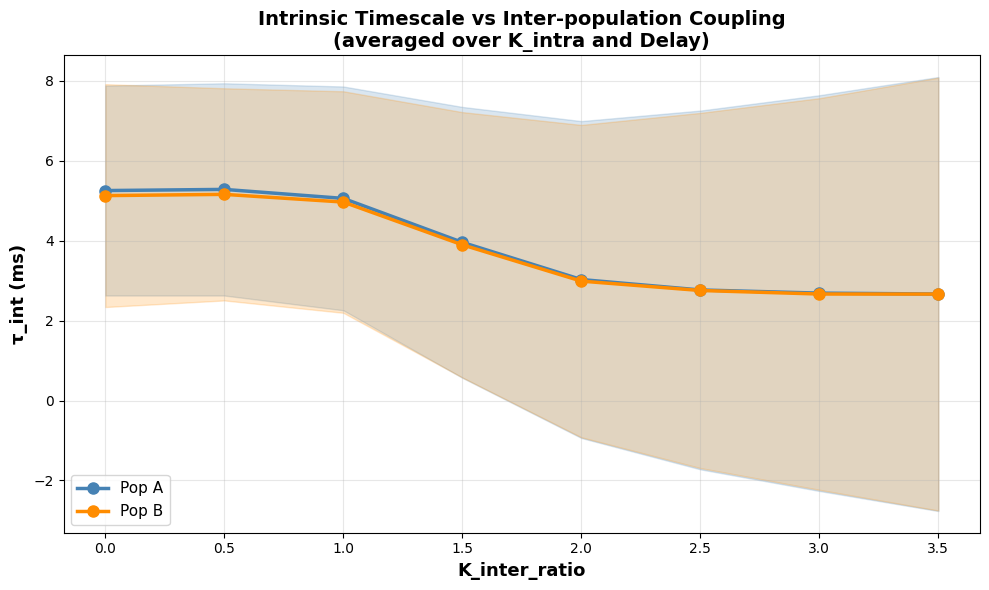

In [10]:
def plot_tau_vs_kinter_ratio(arrays_3d, output_dir=None):
    """τ_int vs K_inter_ratio promediando sobre K_intra y Delay"""
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    
    for pop in ['A', 'B']:
        # Promediar sobre dimensiones 0 (K_intra) y 2 (Delay)
        tau_mean = np.nanmean(arrays_3d[f'tau_int_{pop}'], axis=(0, 2))
        tau_std = np.nanstd(arrays_3d[f'tau_int_{pop}'], axis=(0, 2))
        
        ax.plot(K_INTER_RATIOS, tau_mean, 'o-', 
                linewidth=2.5, markersize=8, 
                color=colors[pop], label=f'Pop {pop}')
        
        ax.fill_between(K_INTER_RATIOS, 
                        tau_mean - tau_std, 
                        tau_mean + tau_std,
                        alpha=0.2, color=colors[pop])
    
    ax.set_xlabel('K_inter_ratio', fontsize=13, weight='bold')
    ax.set_ylabel('τ_int (ms)', fontsize=13, weight='bold')
    ax.set_title('Intrinsic Timescale vs Inter-population Coupling\n(averaged over K_intra and Delay)', 
                 fontsize=14, weight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(output_dir / "tau_vs_kinter_ratio_comparison.png", 
                   dpi=200, bbox_inches='tight')
    plt.show()

# Uso
plot_tau_vs_kinter_ratio(arrays_3d, sweep_dir)

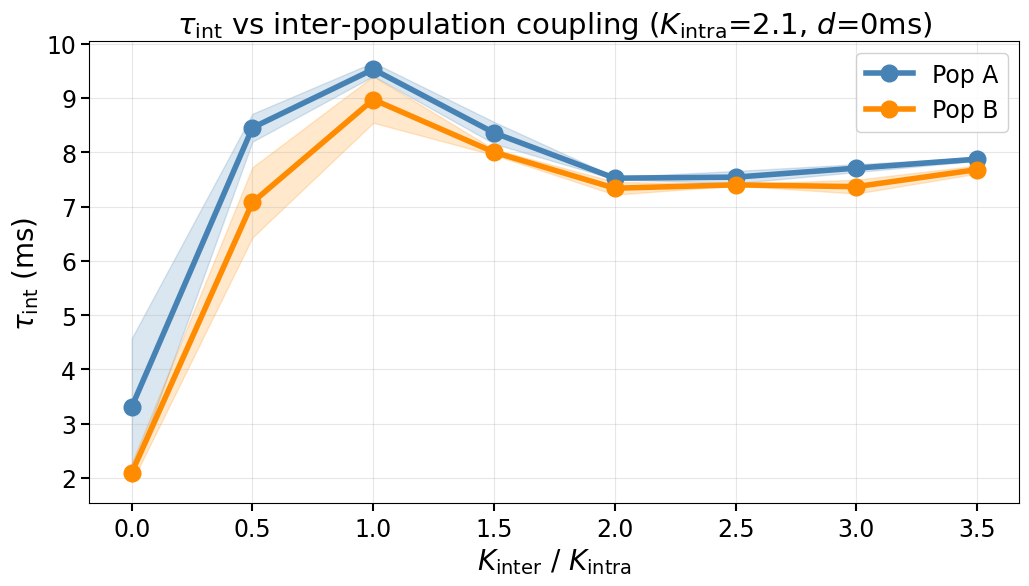

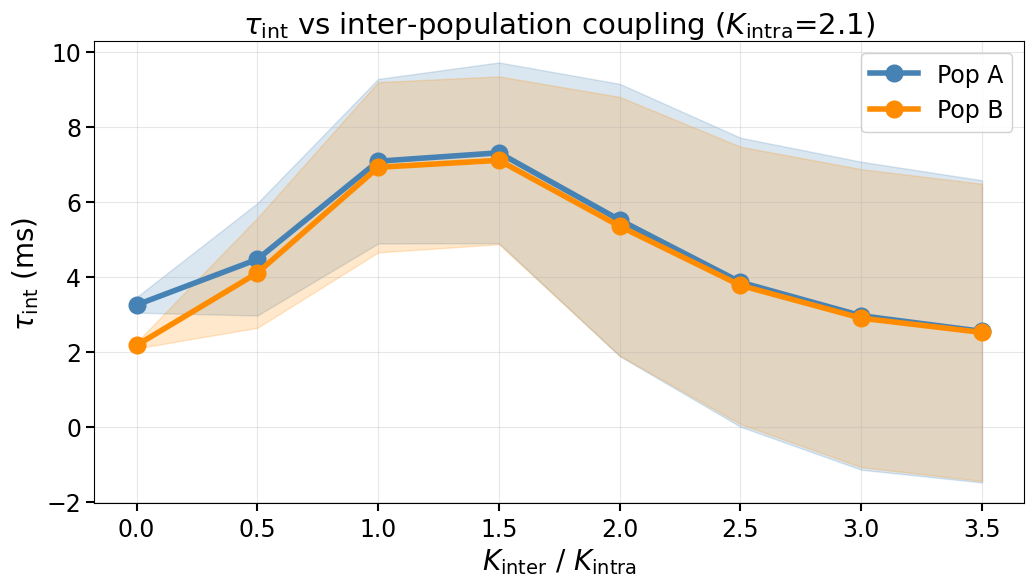

In [11]:
def plot_tau_vs_kinter_fixed_kintra(arrays_3d, k_intra_value, output_dir=None):
    """τ_int vs K_inter para K_intra fijo"""
    
    k_idx = np.argmin(np.abs(K_INTRA_VALUES - k_intra_value))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    
    for pop in ['A', 'B']:
        tau_mean = np.nanmean(arrays_3d[f'tau_int_{pop}'][k_idx, :, :], axis=1)
        tau_std = np.nanstd(arrays_3d[f'tau_int_{pop}'][k_idx, :, :], axis=1)
        
        ax.plot(K_INTER_RATIOS, tau_mean, 'o-', 
                linewidth=4, markersize=12,
                color=colors[pop], label=f'Pop {pop}')
        ax.fill_between(K_INTER_RATIOS, tau_mean - tau_std, tau_mean + tau_std,
                        alpha=0.2, color=colors[pop])
    
    ax.set_xlabel(r'$K_{\mathrm{inter}}$ / $K_{\mathrm{intra}}$', fontsize=20)
    ax.set_ylabel(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=20)
    ax.set_title(rf'$\tau_{{\mathrm{{int}}}}$ vs inter-population coupling ($K_{{\mathrm{{intra}}}}$={K_INTRA_VALUES[k_idx]:.1f})',
                 fontsize=21)
    ax.legend(fontsize=17, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=17, width=1.5, length=6)
    
    if output_dir:
        plt.savefig(output_dir / f"tau_vs_kinter_kintra{K_INTRA_VALUES[k_idx]:.1f}.png",
                   dpi=200, bbox_inches='tight')
    plt.show()


def plot_tau_vs_kinter_fixed_kintra_delay(arrays_3d, k_intra_value, delay_value, output_dir=None):
    """τ_int vs K_inter para K_intra y delay fijos"""
    
    k_idx = np.argmin(np.abs(K_INTRA_VALUES - k_intra_value))
    d_idx = np.argmin(np.abs(DELAY_VALUES - delay_value))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    
    for pop in ['A', 'B']:
        tau_vals = arrays_3d[f'tau_int_{pop}'][k_idx, :, d_idx]
        
        if f'tau_int_{pop}_std' in arrays_3d:
            tau_std = arrays_3d[f'tau_int_{pop}_std'][k_idx, :, d_idx]
            ax.fill_between(K_INTER_RATIOS, tau_vals - tau_std, tau_vals + tau_std,
                           alpha=0.2, color=colors[pop])
        
        ax.plot(K_INTER_RATIOS, tau_vals, 'o-', 
                linewidth=4, markersize=12,
                color=colors[pop], label=f'Pop {pop}')
    
    ax.set_xlabel(r'$K_{\mathrm{inter}}$ / $K_{\mathrm{intra}}$', fontsize=20)
    ax.set_ylabel(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=20)
    ax.set_title(rf'$\tau_{{\mathrm{{int}}}}$ vs inter-population coupling ($K_{{\mathrm{{intra}}}}$={K_INTRA_VALUES[k_idx]:.1f}, $d$={DELAY_VALUES[d_idx]:.0f}ms)',
                 fontsize=21)
    ax.legend(fontsize=17, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=17, width=1.5, length=6)
    
    if output_dir:
        plt.savefig(output_dir / f"tau_vs_kinter_K{K_INTRA_VALUES[k_idx]:.1f}_d{DELAY_VALUES[d_idx]:.0f}ms.png",
                   dpi=200, bbox_inches='tight')
    plt.show()


# Uso
plot_tau_vs_kinter_fixed_kintra_delay(arrays_3d, k_intra_value=2.1, delay_value=0, output_dir=sweep_dir)
plot_tau_vs_kinter_fixed_kintra(arrays_3d, k_intra_value=2.0, output_dir=sweep_dir)

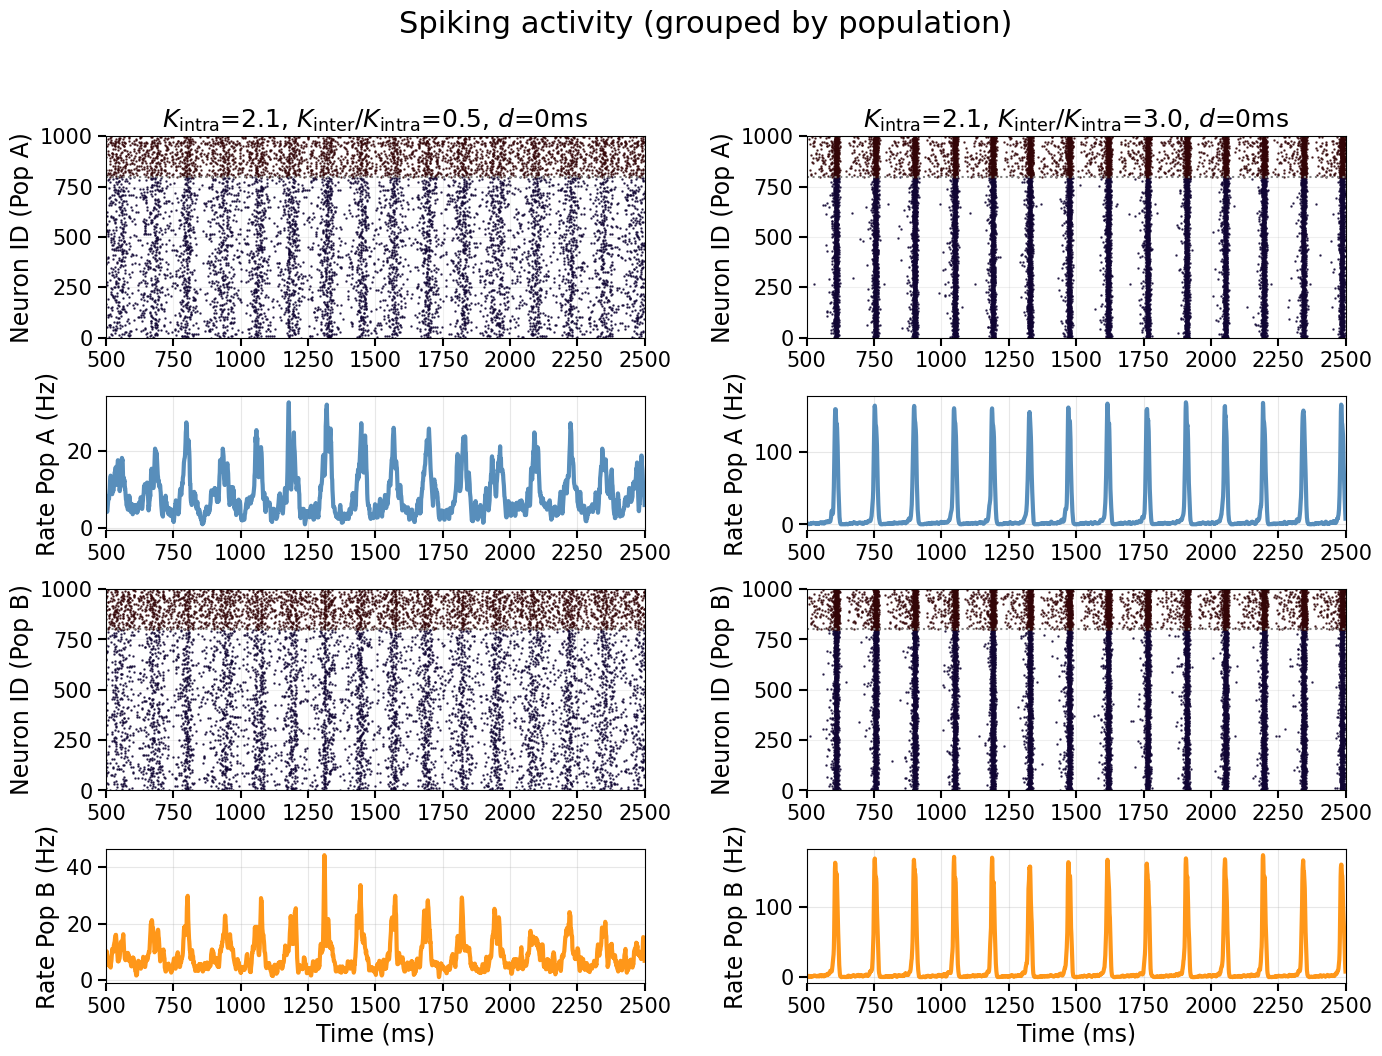

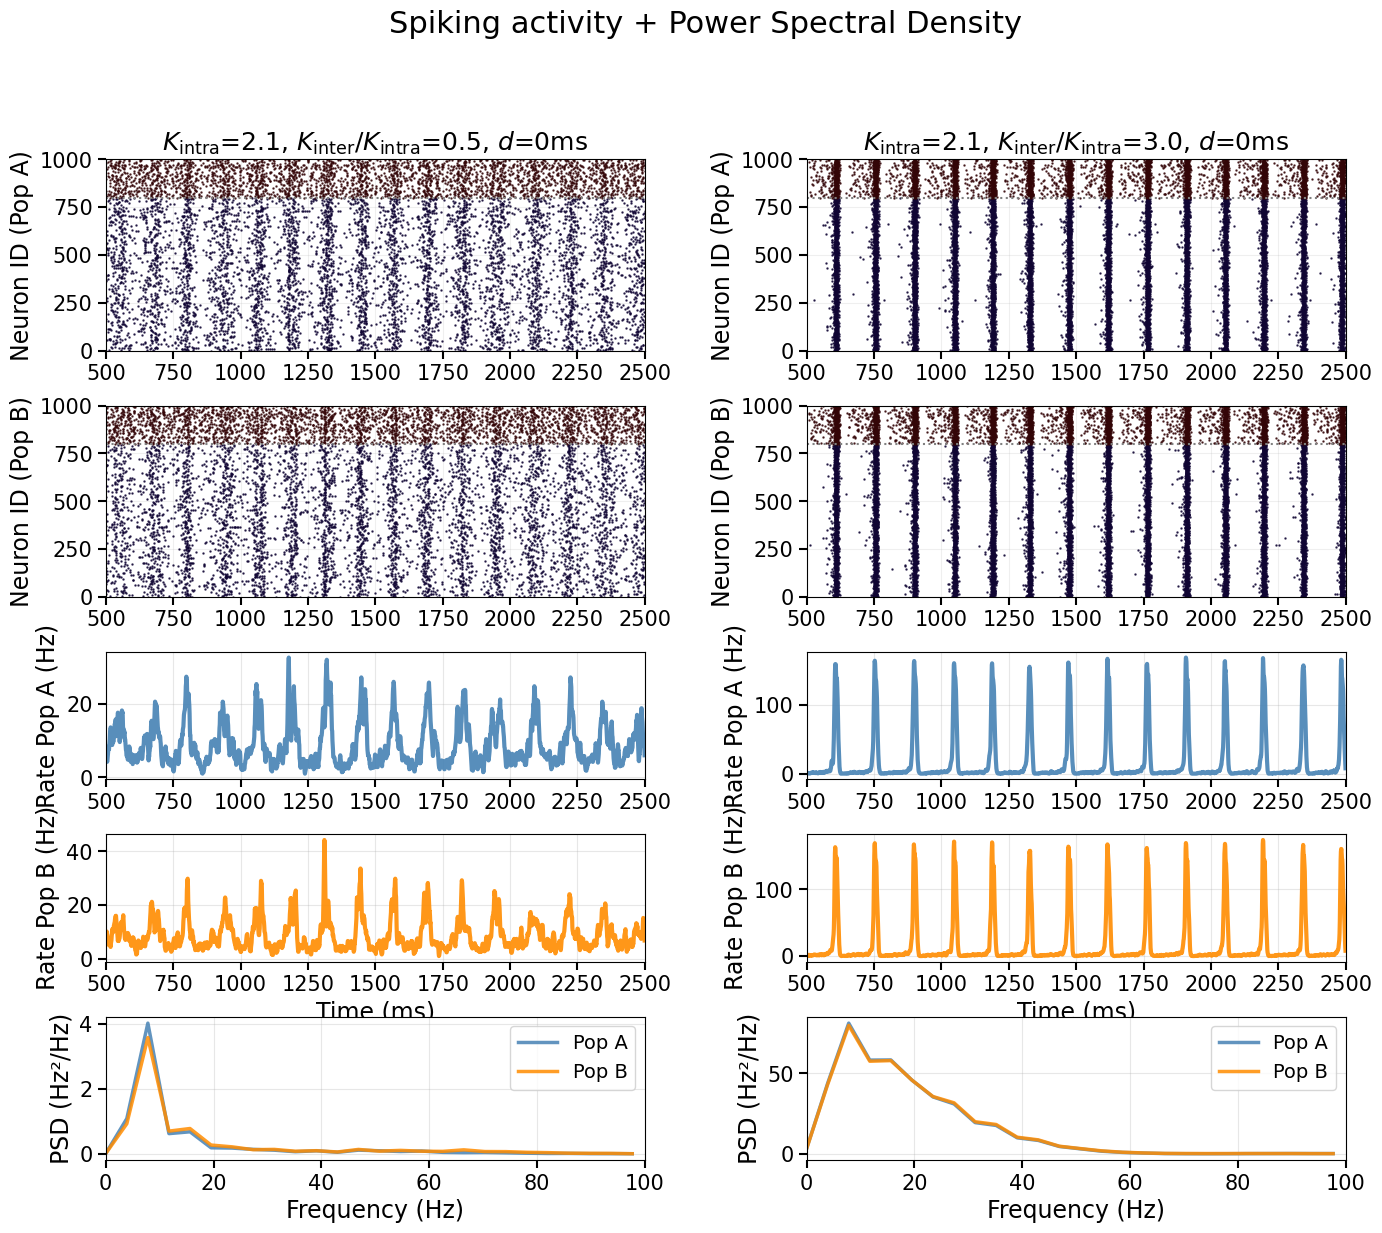

In [ ]:
def plot_raster_and_fr_by_population(output_dir, cases_list, warmup_ms=500, 
                                     neuron_limit=1000, time_window=(500, 1500)):
    """Raster + FR agrupados POR POBLACIÓN: A_raster, A_FR, B_raster, B_FR"""
    
    n_cases = len(cases_list)
    fig = plt.figure(figsize=(8*n_cases, 11))
    gs = fig.add_gridspec(4, n_cases, hspace=0.35, wspace=0.3, 
                         height_ratios=[1.2, 0.8, 1.2, 0.8])
    
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    N_exc = 800
    
    for case_idx, case in enumerate(cases_list):
        case_data = None
        for h5_file in sorted((output_dir / "raw_spikes").glob("batch_*.h5")):
            with h5py.File(h5_file, 'r') as f:
                for key in f.keys():
                    grp = f[key]
                    if (np.isclose(grp.attrs['k_intra'], case['k_intra'], atol=0.1) and
                        np.isclose(grp.attrs['k_inter_ratio'], case['k_inter_ratio'], atol=0.1) and
                        np.isclose(grp.attrs['delay_ms'], case['delay'], atol=0.1)):
                        case_data = (h5_file, key)
                        break
            if case_data:
                break
        
        if not case_data:
            print(f"Case not found: {case}")
            continue
        
        with h5py.File(case_data[0], 'r') as f:
            grp = f[case_data[1]]
            case_label = (rf"$K_{{\mathrm{{intra}}}}$={grp.attrs['k_intra']:.1f}, "
                         rf"$K_{{\mathrm{{inter}}}}/K_{{\mathrm{{intra}}}}$={grp.attrs['k_inter_ratio']:.1f}, "
                         rf"$d$={grp.attrs['delay_ms']:.0f}ms")
            
            for pop_idx, pop in enumerate(['A', 'B']):
                # Raster (fila 0 o 2)
                ax_raster = fig.add_subplot(gs[pop_idx*2, case_idx])
                
                spike_times = grp[f'spikes_{pop}_times'][:]
                spike_neurons = grp[f'spikes_{pop}_neurons'][:]
                
                mask = (spike_times >= warmup_ms) & (spike_times <= time_window[1])
                if neuron_limit:
                    mask &= (spike_neurons < neuron_limit) & (spike_neurons % 2 == 0)
                
                t_plot = spike_times[mask]
                i_plot = spike_neurons[mask]
                
                exc_mask = (i_plot < N_exc)
                ax_raster.plot(t_plot[exc_mask], i_plot[exc_mask], '.', 
                              color='#100533', markersize=1.5, alpha=0.8)
                ax_raster.plot(t_plot[~exc_mask], i_plot[~exc_mask], '.', 
                             color='#330507', markersize=1.5, alpha=0.8)
                
                ax_raster.axhline(N_exc, color='gray', ls=':', lw=1.5)
                ax_raster.set_xlim(time_window)
                ax_raster.set_ylim(0, neuron_limit if neuron_limit else 1000)
                ax_raster.set_ylabel(f'Neuron ID (Pop {pop})', fontsize=17)
                ax_raster.tick_params(axis='both', which='major', labelsize=15, 
                                     width=1.5, length=6)
                ax_raster.grid(alpha=0.2)
                
                if pop_idx == 0:
                    ax_raster.set_title(case_label, fontsize=18)
                
                # FR (fila 1 o 3)
                ax_fr = fig.add_subplot(gs[pop_idx*2 + 1, case_idx])
                
                from src.two_populations.metrics import spikes_to_population_rate
                time_fr, rate_fr = spikes_to_population_rate(
                    type('obj', (), {'t': spike_times*ms, 'i': spike_neurons})(),
                    1000, smooth_window=5, analysis_dt=1.0, T_total=time_window[1]
                )
                
                mask_fr = (time_fr >= time_window[0]) & (time_fr <= time_window[1])
                ax_fr.plot(time_fr[mask_fr], rate_fr[mask_fr], lw=3, 
                          color=colors[pop], alpha=0.9)
                ax_fr.set_xlim(time_window)
                ax_fr.set_ylabel(f'Rate Pop {pop} (Hz)', fontsize=17)
                ax_fr.tick_params(axis='both', which='major', labelsize=15, 
                                 width=1.5, length=6)
                ax_fr.grid(alpha=0.3)
                
                if pop_idx == 1:
                    ax_fr.set_xlabel('Time (ms)', fontsize=17)
    
    plt.suptitle('Spiking activity (grouped by population)', fontsize=22, y=0.995)
    plt.savefig(output_dir / 'raster_fr_by_population.png', dpi=200, bbox_inches='tight')
    plt.show()


def plot_raster_fr_psd_by_type(output_dir, cases_list, warmup_ms=500, 
                                neuron_limit=1000, time_window=(500, 1500),
                                freq_range=(0, 100)):
    """
    Raster + FR + PSD agrupados POR TIPO:
    - Fila 0: Raster A
    - Fila 1: Raster B
    - Fila 2: FR A
    - Fila 3: FR B
    - Fila 4: PSD A y B superpuestos
    """
    
    n_cases = len(cases_list)
    fig = plt.figure(figsize=(8*n_cases, 13))
    gs = fig.add_gridspec(5, n_cases, hspace=0.35, wspace=0.3, 
                         height_ratios=[1.2, 1.2, 0.8, 0.8, 0.9])
    
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    N_exc = 800
    
    for case_idx, case in enumerate(cases_list):
        # ===============================================
        # 1. BÚSQUEDA DEL CASO EN HDF5
        # ===============================================
        case_data = None
        for h5_file in sorted((output_dir / "raw_spikes").glob("batch_*.h5")):
            with h5py.File(h5_file, 'r') as f:
                for key in f.keys():
                    grp = f[key]
                    if (np.isclose(grp.attrs['k_intra'], case['k_intra'], atol=0.1) and
                        np.isclose(grp.attrs['k_inter_ratio'], case['k_inter_ratio'], atol=0.1) and
                        np.isclose(grp.attrs['delay_ms'], case['delay'], atol=0.1)):
                        case_data = (h5_file, key)
                        break
            if case_data:
                break
        
        if not case_data:
            print(f"⚠️  Case not found: {case}")
            continue
        
        with h5py.File(case_data[0], 'r') as f:
            grp = f[case_data[1]]
            case_label = (rf"$K_{{\mathrm{{intra}}}}$={grp.attrs['k_intra']:.1f}, "
                         rf"$K_{{\mathrm{{inter}}}}/K_{{\mathrm{{intra}}}}$={grp.attrs['k_inter_ratio']:.1f}, "
                         rf"$d$={grp.attrs['delay_ms']:.0f}ms")
            
            # ===============================================
            # 2. RASTERS A y B (filas 0 y 1)
            # ===============================================
            for pop_idx, pop in enumerate(['A', 'B']):
                ax_raster = fig.add_subplot(gs[pop_idx, case_idx])
                
                spike_times = grp[f'spikes_{pop}_times'][:]
                spike_neurons = grp[f'spikes_{pop}_neurons'][:]
                
                mask = (spike_times >= warmup_ms) & (spike_times <= time_window[1])
                if neuron_limit:
                    mask &= (spike_neurons < neuron_limit) & (spike_neurons % 2 == 0)
                
                t_plot = spike_times[mask]
                i_plot = spike_neurons[mask]
                
                exc_mask = (i_plot < N_exc)
                ax_raster.plot(t_plot[exc_mask], i_plot[exc_mask], '.', 
                              color='#100533', markersize=1.5, alpha=0.8)
                ax_raster.plot(t_plot[~exc_mask], i_plot[~exc_mask], '.', 
                             color='#330507', markersize=1.5, alpha=0.8)
                
                ax_raster.axhline(N_exc, color='gray', ls=':', lw=1.5)
                ax_raster.set_xlim(time_window)
                ax_raster.set_ylim(0, neuron_limit if neuron_limit else 1000)
                ax_raster.set_ylabel(f'Neuron ID (Pop {pop})', fontsize=17)
                ax_raster.tick_params(axis='both', which='major', labelsize=15, 
                                     width=1.5, length=6)
                ax_raster.grid(alpha=0.2)
                
                if pop_idx == 0:
                    ax_raster.set_title(case_label, fontsize=18)
            
            # ===============================================
            # 3. FIRING RATES A y B (filas 2 y 3)
            # ===============================================
            rates_dict = {}  # Guardar para calcular PSD después
            
            for pop_idx, pop in enumerate(['A', 'B']):
                ax_fr = fig.add_subplot(gs[2 + pop_idx, case_idx])
                
                spike_times = grp[f'spikes_{pop}_times'][:]
                spike_neurons = grp[f'spikes_{pop}_neurons'][:]
                
                from src.two_populations.metrics import spikes_to_population_rate
                time_fr, rate_fr = spikes_to_population_rate(
                    type('obj', (), {'t': spike_times*ms, 'i': spike_neurons})(),
                    1000, smooth_window=5, analysis_dt=1.0, T_total=time_window[1]
                )
                
                # Guardar para PSD
                mask_fr = (time_fr >= time_window[0]) & (time_fr <= time_window[1])
                rates_dict[pop] = {'time': time_fr[mask_fr], 'rate': rate_fr[mask_fr]}
                
                ax_fr.plot(time_fr[mask_fr], rate_fr[mask_fr], lw=3, 
                          color=colors[pop], alpha=0.9)
                ax_fr.set_xlim(time_window)
                ax_fr.set_ylabel(f'Rate Pop {pop} (Hz)', fontsize=17)
                ax_fr.tick_params(axis='both', which='major', labelsize=15, 
                                 width=1.5, length=6)
                ax_fr.grid(alpha=0.3)
                
                if pop_idx == 1:
                    ax_fr.set_xlabel('Time (ms)', fontsize=17)
            
            # ===============================================
            # 4. ESPECTRO DE POTENCIAS (fila 4)
            # ===============================================
            ax_psd = fig.add_subplot(gs[4, case_idx])
            
            from scipy.signal import welch
            
            for pop in ['A', 'B']:
                rate = rates_dict[pop]['rate']
                dt_ms = np.mean(np.diff(rates_dict[pop]['time']))  # Intervalo temporal en ms
                fs = 1000.0 / dt_ms  # Frecuencia de muestreo en Hz
                
                # Welch PSD: nperseg define resolución espectral
                freqs, psd = welch(rate, fs=fs, nperseg=min(256, len(rate)//4))
                
                # Filtrar rango de frecuencias de interés
                mask_freq = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
                
                ax_psd.plot(freqs[mask_freq], psd[mask_freq], 
                               lw=2.5, color=colors[pop], alpha=0.85, label=f'Pop {pop}')
            
            ax_psd.set_xlabel('Frequency (Hz)', fontsize=17)
            ax_psd.set_ylabel('PSD (Hz²/Hz)', fontsize=17)
            ax_psd.set_xlim(freq_range)
            ax_psd.tick_params(axis='both', which='major', labelsize=15, 
                              width=1.5, length=6)
            ax_psd.legend(fontsize=14, frameon=True, loc='best')
            ax_psd.grid(alpha=0.3, which='both')
    
    plt.suptitle('Spiking activity + Power Spectral Density', fontsize=22, y=0.995)
    plt.savefig(output_dir / 'raster_fr_psd_by_type.png', dpi=200, bbox_inches='tight')
    plt.show()

# Uso
cases = [
    {'k_intra': 2.1, 'k_inter_ratio': 1.0, 'delay':15},
    {'k_intra': 2.1, 'k_inter_ratio': 1.0, 'delay':0}
    
]

from scipy.signal import welch

# Versión 1: Por población (A_raster, A_FR, B_raster, B_FR)
plot_raster_and_fr_by_population(sweep_dir, cases, time_window=(500, 2500))

# Versión 2: Por tipo (A_raster, B_raster, A_FR, B_FR)
plot_raster_fr_psd_by_type(sweep_dir, cases, time_window=(500, 2500))

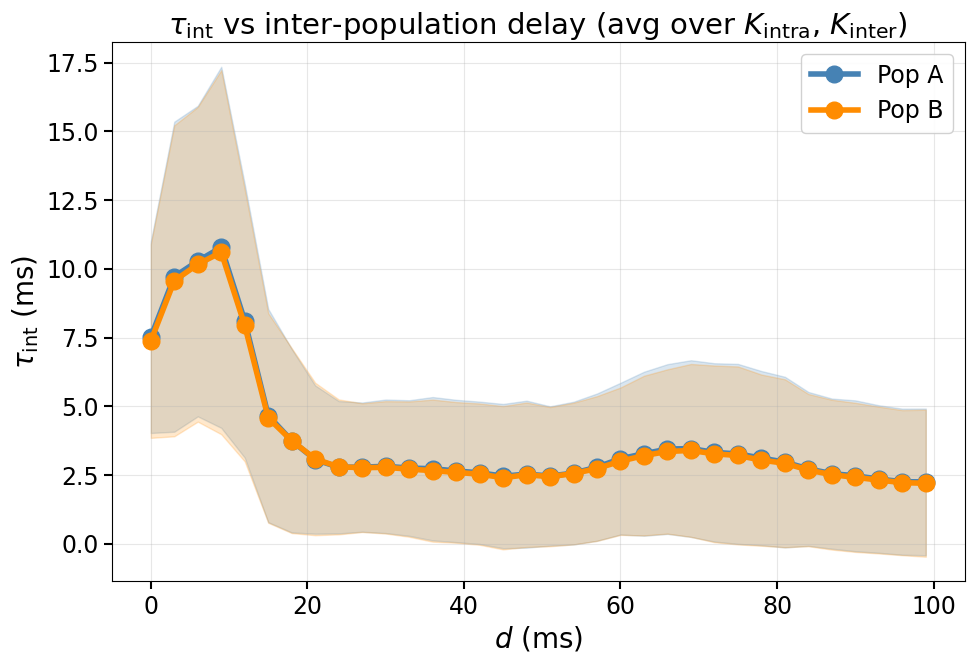

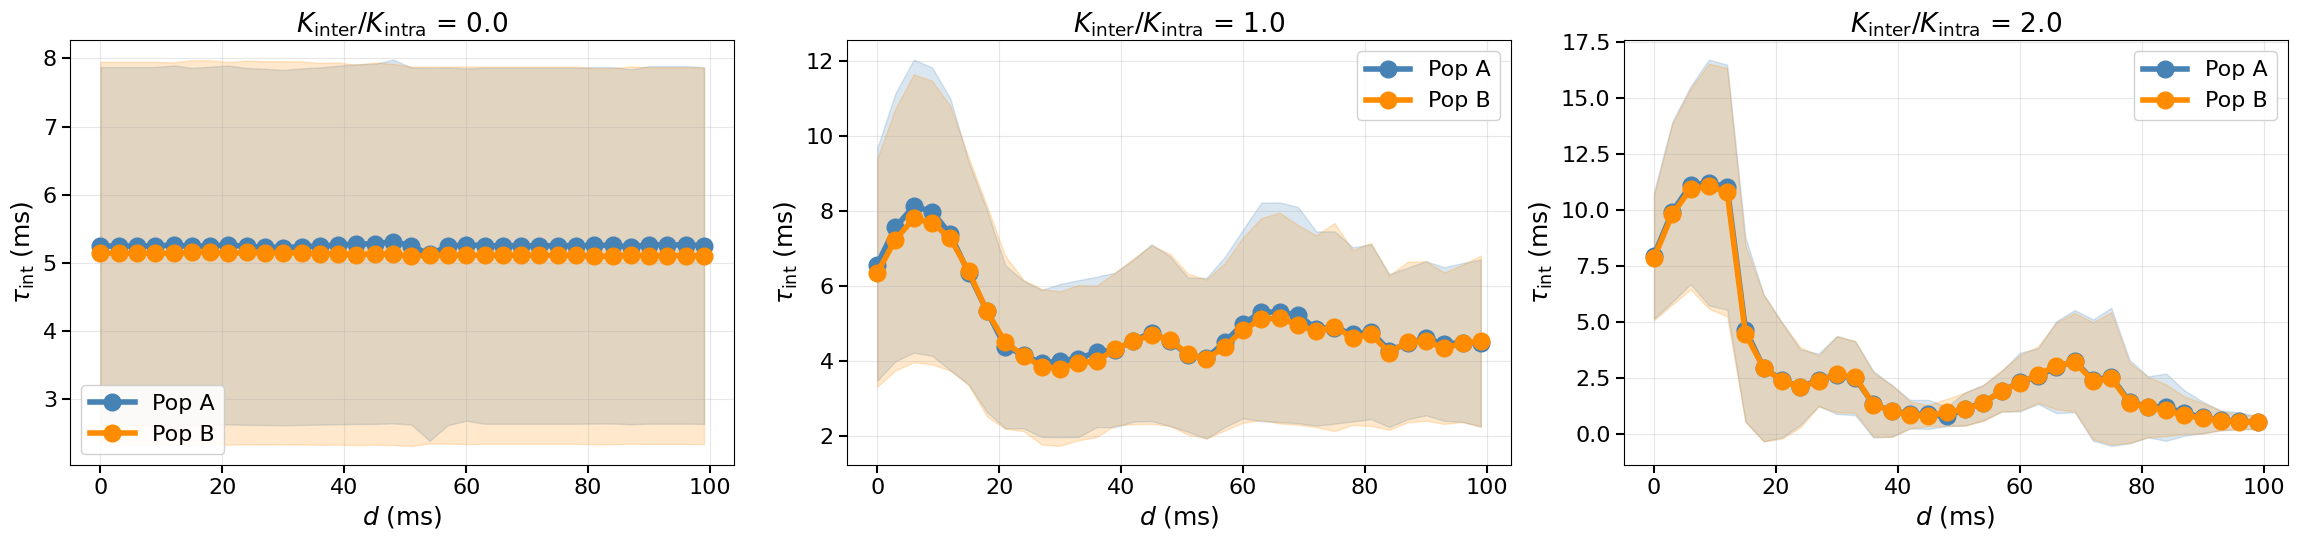

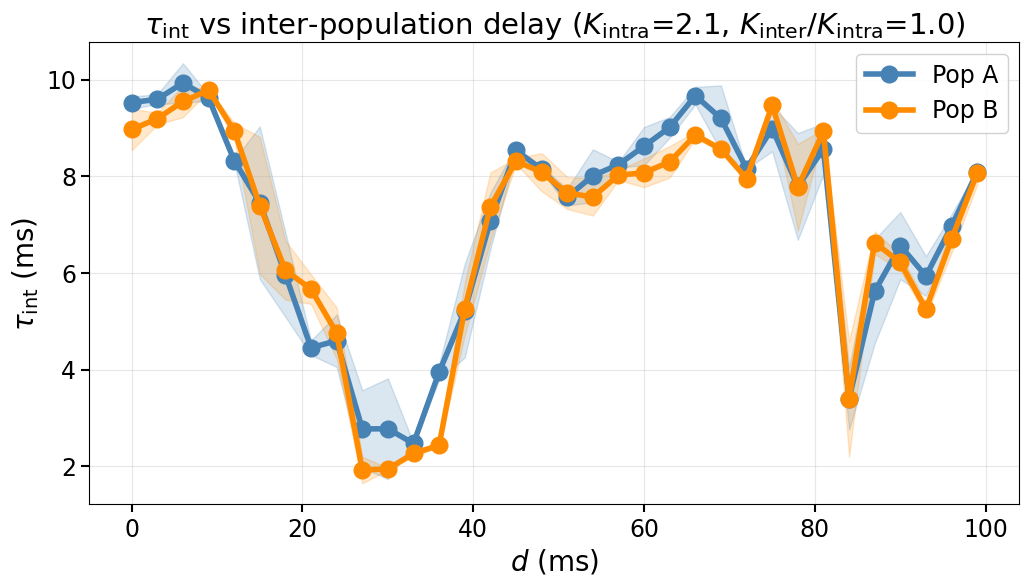

In [13]:
def plot_tau_vs_delay_averaged(arrays_3d, output_dir=None):
    """τ_int vs Delay (promediado sobre K_intra y K_inter_ratio)"""
    
    fig, ax = plt.subplots(figsize=(11, 7))
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    
    for pop in ['A', 'B']:
        tau_mean = np.nanmean(arrays_3d[f'tau_int_{pop}'], axis=(0, 1))
        tau_std = np.nanstd(arrays_3d[f'tau_int_{pop}'], axis=(0, 1))
        
        ax.plot(DELAY_VALUES, tau_mean, 'o-', lw=4, ms=12, 
                color=colors[pop], label=f'Pop {pop}')
        ax.fill_between(DELAY_VALUES, tau_mean - tau_std, tau_mean + tau_std,
                        alpha=0.2, color=colors[pop])
    
    ax.set_xlabel(r'$d$ (ms)', fontsize=20)
    ax.set_ylabel(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=20)
    ax.set_title(r'$\tau_{\mathrm{int}}$ vs inter-population delay (avg over $K_{\mathrm{intra}}$, $K_{\mathrm{inter}}$)', 
                 fontsize=21)
    ax.legend(fontsize=17, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=17, width=1.5, length=6)
    
    if output_dir:
        plt.savefig(output_dir / "tau_vs_delay_full_avg.png", dpi=200, bbox_inches='tight')
    plt.show()


def plot_tau_vs_delay_fixed_kinter(arrays_3d, k_inter_ratios, output_dir=None):
    """τ_int vs Delay para K_inter_ratio específicos (promediado sobre K_intra)"""
    
    n_plots = len(k_inter_ratios)
    fig, axes = plt.subplots(1, n_plots, figsize=(7.7*n_plots, 5.5))
    if n_plots == 1:
        axes = [axes]
    
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    
    for ax, k_inter_val in zip(axes, k_inter_ratios):
        r_idx = np.argmin(np.abs(K_INTER_RATIOS - k_inter_val))
        
        for pop in ['A', 'B']:
            tau_mean = np.nanmean(arrays_3d[f'tau_int_{pop}'][:, r_idx, :], axis=0)
            tau_std = np.nanstd(arrays_3d[f'tau_int_{pop}'][:, r_idx, :], axis=0)
            
            ax.plot(DELAY_VALUES, tau_mean, 'o-', lw=4, ms=12,
                   color=colors[pop], label=f'Pop {pop}')
            ax.fill_between(DELAY_VALUES, tau_mean - tau_std, tau_mean + tau_std,
                           alpha=0.2, color=colors[pop])
        
        ax.set_xlabel(r'$d$ (ms)', fontsize=18)
        ax.set_ylabel(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=18)
        ax.set_title(rf'$K_{{\mathrm{{inter}}}} / K_{{\mathrm{{intra}}}}$ = {K_INTER_RATIOS[r_idx]:.1f}', 
                    fontsize=19)
        ax.legend(fontsize=16, framealpha=0.9)
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=16, width=1.5, length=6)
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(output_dir / "tau_vs_delay_fixed_kinter.png", dpi=200, bbox_inches='tight')
    plt.show()


def plot_tau_vs_delay_specific(arrays_3d, k_intra_val, k_inter_val, output_dir=None):
    """τ_int vs Delay para K_intra y K_inter_ratio específicos"""
    
    k_idx = np.argmin(np.abs(K_INTRA_VALUES - k_intra_val))
    r_idx = np.argmin(np.abs(K_INTER_RATIOS - k_inter_val))
    
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    
    for pop in ['A', 'B']:
        tau_curve = arrays_3d[f'tau_int_{pop}'][k_idx, r_idx, :]
        tau_std = arrays_3d[f'tau_int_{pop}_std'][k_idx, r_idx, :]
        
        ax.plot(DELAY_VALUES, tau_curve, 'o-', lw=4, ms=12,
               color=colors[pop], label=f'Pop {pop}')
        ax.fill_between(DELAY_VALUES, tau_curve - tau_std, tau_curve + tau_std,
                       alpha=0.2, color=colors[pop])
    
    ax.set_xlabel(r'$d$ (ms)', fontsize=20)
    ax.set_ylabel(r'$\tau_{\mathrm{int}}$ (ms)', fontsize=20)
    ax.set_title(rf'$\tau_{{\mathrm{{int}}}}$ vs inter-population delay ($K_{{\mathrm{{intra}}}}$={K_INTRA_VALUES[k_idx]:.1f}, $K_{{\mathrm{{inter}}}}/K_{{\mathrm{{intra}}}}$={K_INTER_RATIOS[r_idx]:.1f})',
                fontsize=21)
    ax.legend(fontsize=17, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=17, width=1.5, length=6)
    
    if output_dir:
        plt.savefig(output_dir / f"tau_vs_delay_k{K_INTRA_VALUES[k_idx]:.1f}_r{K_INTER_RATIOS[r_idx]:.1f}.png",
                   dpi=200, bbox_inches='tight')
    plt.show()


# Uso:
plot_tau_vs_delay_averaged(arrays_3d, sweep_dir)
plot_tau_vs_delay_fixed_kinter(arrays_3d, k_inter_ratios=[0.0, 1.0, 2.0], output_dir=sweep_dir)
plot_tau_vs_delay_specific(arrays_3d, k_intra_val=2.1, k_inter_val=1.0, output_dir=sweep_dir)

In [1]:
from scipy.ndimage import gaussian_filter1d

def plot_case_compare_pops(arrays_3d, case, output_dir, smooth_sigma=0.5):
    """AC promediada sobre trials - comparación A vs B"""
    
    colors = {'A': 'steelblue', 'B': 'darkorange'}
    
    k_idx = np.argmin(np.abs(K_INTRA_VALUES - case['k_intra']))
    r_idx = np.argmin(np.abs(K_INTER_RATIOS - case['k_inter_ratio']))
    d_idx = np.argmin(np.abs(DELAY_VALUES - case['delay']))
    
    # Recoger TODOS los trials
    all_acs = {'A': [], 'B': []}
    lags = None
    
    for h5_file in sorted((output_dir / "raw_spikes").glob("batch_*.h5")):
        with h5py.File(h5_file, 'r') as f:
            for key in f.keys():
                grp = f[key]
                if (np.isclose(grp.attrs['k_intra'], case['k_intra'], atol=0.1) and
                    np.isclose(grp.attrs['k_inter_ratio'], case['k_inter_ratio'], atol=0.1) and
                    np.isclose(grp.attrs['delay_ms'], case['delay'], atol=0.1)):
                    for pop in ['A', 'B']:
                        all_acs[pop].append(grp[f'metrics/{pop}/ac_corr'][:])
                        if lags is None:
                            lags = grp[f'metrics/{pop}/ac_lags'][:]
    
    if not all_acs['A']:
        print(f"Case not found: {case}")
        return
    
    fig, ax = plt.subplots(figsize=(11, 7))
    max_lag = 0
    
    for pop in ['A', 'B']:
        corr_mean = np.mean(all_acs[pop], axis=0)
        tau_int = arrays_3d[f'tau_int_{pop}'][k_idx, r_idx, d_idx]
        
        pos = (lags >= 0)
        lags_pos = lags[pos]
        corr_pos = gaussian_filter1d(corr_mean[pos], sigma=smooth_sigma)
        
        zero_idx = np.where(corr_pos <= 0.1)[0]
        if len(zero_idx) > 0:
            end_idx = zero_idx[0]
            max_lag = max(max_lag, lags_pos[end_idx])
            ax.plot(lags_pos[:end_idx], corr_pos[:end_idx], lw=4, alpha=0.9,
                   color=colors[pop], label=rf'Pop {pop} ($\tau={tau_int:.1f}$ ms)')
            ax.fill_between(lags_pos[:end_idx], 0.1, corr_pos[:end_idx], alpha=0.2, color=colors[pop])
    
    ax.axhline(0, color='k', ls='--', lw=1.5, alpha=0.4)
    ax.axhline(0.1, color='red', ls='--', lw=2, alpha=0.7, label='Threshold')
    ax.set_xlabel('Lag (ms)', fontsize=20)
    ax.set_ylabel('Autocorrelation', fontsize=20)
    ax.set_title(rf"$K_{{\mathrm{{intra}}}}$={case['k_intra']:.1f}, $K_{{\mathrm{{inter}}}}/K_{{\mathrm{{intra}}}}$={case['k_inter_ratio']:.1f}, $d$={case['delay']:.0f}ms", 
                 fontsize=21)
    ax.legend(fontsize=17, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=17, width=1.5, length=6)
    ax.set_xlim(0, max_lag + 1)
    ax.set_ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()


def plot_cases_compare_configs(arrays_3d, output_dir, cases_list, smooth_sigma=0.5):
    """Compara múltiples configs con AC promediada"""
    
    colors_cases = plt.cm.tab10(np.arange(len(cases_list)))
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    max_lag_global = 0
    
    for case_idx, case in enumerate(cases_list):
        k_idx = np.argmin(np.abs(K_INTRA_VALUES - case['k_intra']))
        r_idx = np.argmin(np.abs(K_INTER_RATIOS - case['k_inter_ratio']))
        d_idx = np.argmin(np.abs(DELAY_VALUES - case['delay']))
        
        all_acs = {'A': [], 'B': []}
        lags = None
        
        for h5_file in sorted((output_dir / "raw_spikes").glob("batch_*.h5")):
            with h5py.File(h5_file, 'r') as f:
                for key in f.keys():
                    grp = f[key]
                    if (np.isclose(grp.attrs['k_intra'], case['k_intra'], atol=0.1) and
                        np.isclose(grp.attrs['k_inter_ratio'], case['k_inter_ratio'], atol=0.1) and
                        np.isclose(grp.attrs['delay_ms'], case['delay'], atol=0.1)):
                        for pop in ['A', 'B']:
                            all_acs[pop].append(grp[f'metrics/{pop}/ac_corr'][:])
                            if lags is None:
                                lags = grp[f'metrics/A/ac_lags'][:]
        
        if not all_acs['A']:
            continue
        
        for pop_idx, pop in enumerate(['A', 'B']):
            ax = axes[pop_idx]
            corr_mean = np.mean(all_acs[pop], axis=0)
            tau_int = arrays_3d[f'tau_int_{pop}'][k_idx, r_idx, d_idx]
            
            pos = (lags >= 0)
            lags_pos = lags[pos]
            corr_pos = gaussian_filter1d(corr_mean[pos], sigma=smooth_sigma)
            
            zero_idx = np.where(corr_pos <= 0.1)[0]
            if len(zero_idx) > 0:
                end_idx = zero_idx[0]
                max_lag_global = max(max_lag_global, lags_pos[end_idx])
                ax.plot(lags_pos[:end_idx], corr_pos[:end_idx], lw=4, alpha=0.85,
                       color=colors_cases[case_idx], 
                       label=rf'$d$={case["delay"]}ms ($\tau$={tau_int:.1f}ms)')
                ax.fill_between(lags_pos[:end_idx], 0.1, corr_pos[:end_idx], 
                               alpha=0.25, color=colors_cases[case_idx])
    
    for pop_idx, pop in enumerate(['A', 'B']):
        ax = axes[pop_idx]
        ax.axhline(0, color='k', ls='--', lw=1.5, alpha=0.4)
        ax.axhline(0.1, color='red', ls='--', lw=2, alpha=0.7, label='Threshold')
        ax.set_xlabel('Lag (ms)', fontsize=20)
        ax.set_ylabel('Autocorrelation', fontsize=20)
        ax.set_title(f'Pop {pop}', fontsize=21)
        ax.legend(fontsize=15, framealpha=0.9)
        ax.grid(alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=17, width=1.5, length=6)
        ax.set_xlim(0, max_lag_global + 1)
        ax.set_ylim(-0.05, 1.05)
    
    plt.tight_layout()
    plt.show()


# Uso
cases = [
    {'k_intra': 2.1, 'k_inter_ratio': 1.0, 'delay': 15},
    {'k_intra': 2.1, 'k_inter_ratio': 1.0, 'delay': 30},
    {'k_intra': 2.1, 'k_inter_ratio': 1.0, 'delay': 60},
]

plot_cases_compare_configs(arrays_3d, sweep_dir, cases)

# Comparar A vs B
plot_case_compare_pops(arrays_3d, {'k_intra': 2.1, 'k_inter_ratio': 0.4, 'delay': 0}, 
                       output_dir=sweep_dir)
plot_case_compare_pops(arrays_3d, {'k_intra': 2.1, 'k_inter_ratio': 3.0, 'delay': 0}, 
                       output_dir=sweep_dir)

NameError: name 'arrays_3d' is not defined

In [15]:
DELAY_VALUES

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99])

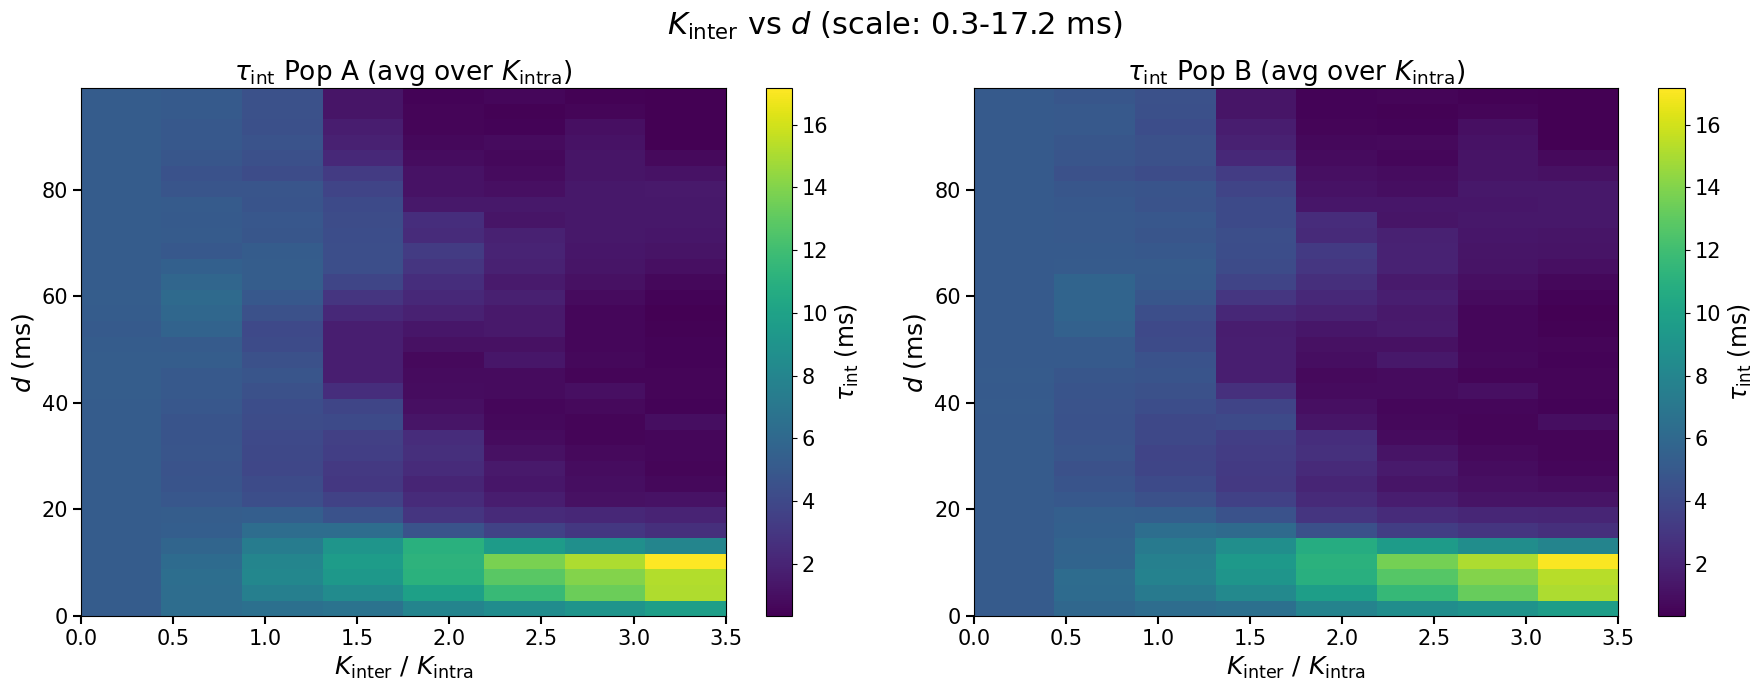

SUCCESS  | __main__:plot_kinter_vs_tau:87 - K_inter vs tau plot saved


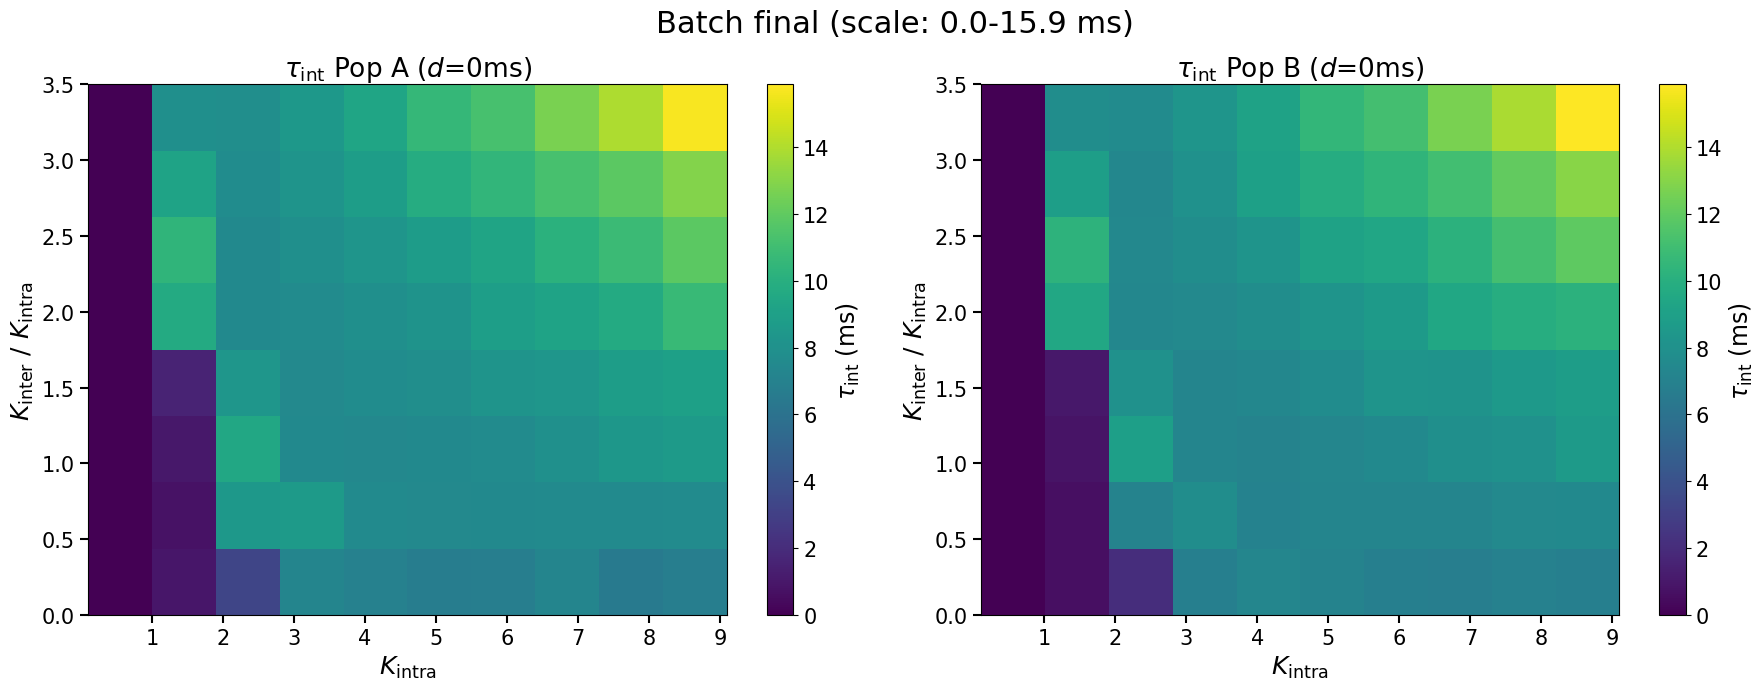

INFO     | __main__:plot_progress_heatmaps:48 - Progress plot saved: heatmap_delay0ms_batchfinal.png


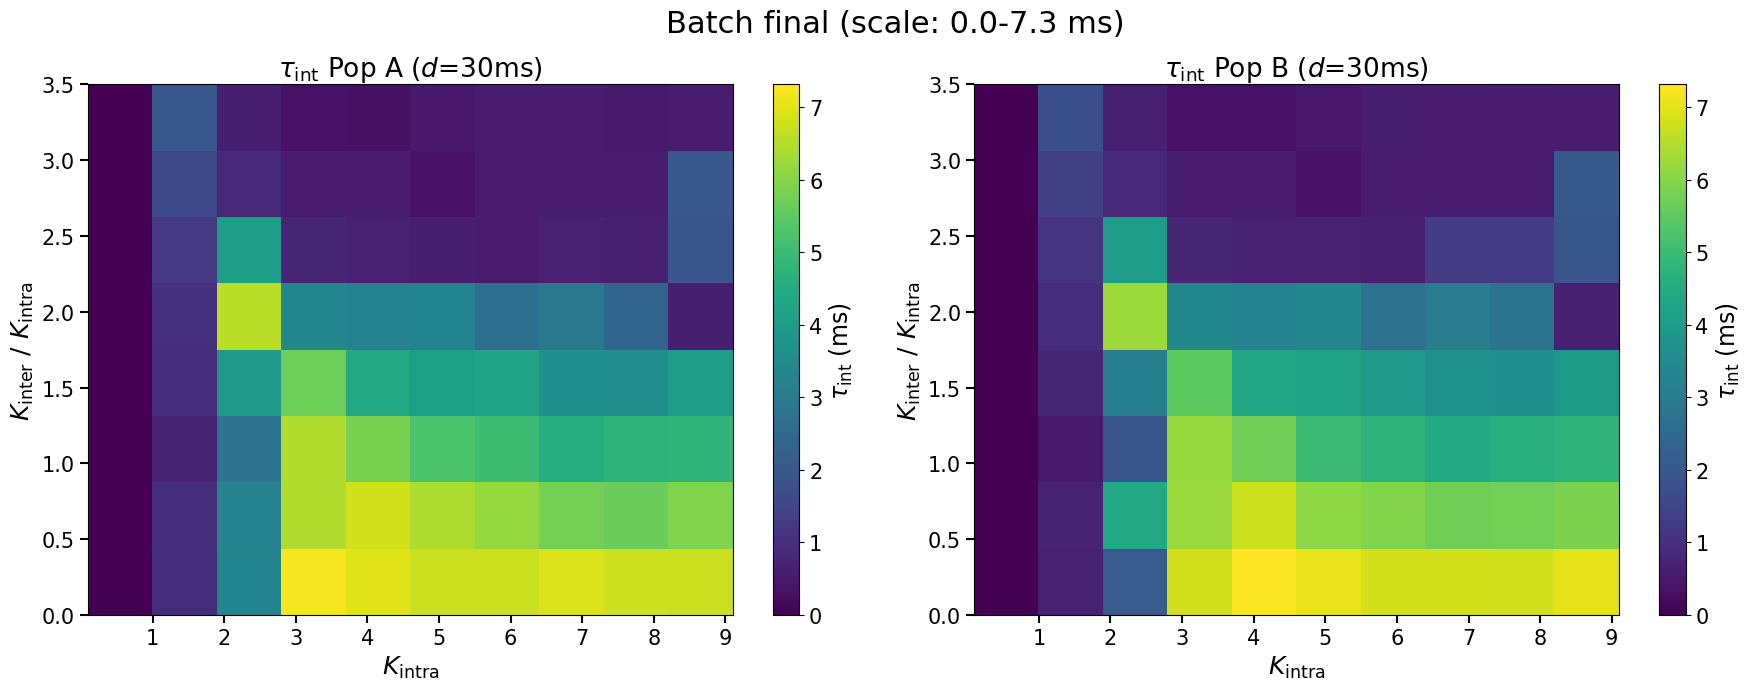

INFO     | __main__:plot_progress_heatmaps:48 - Progress plot saved: heatmap_delay30ms_batchfinal.png


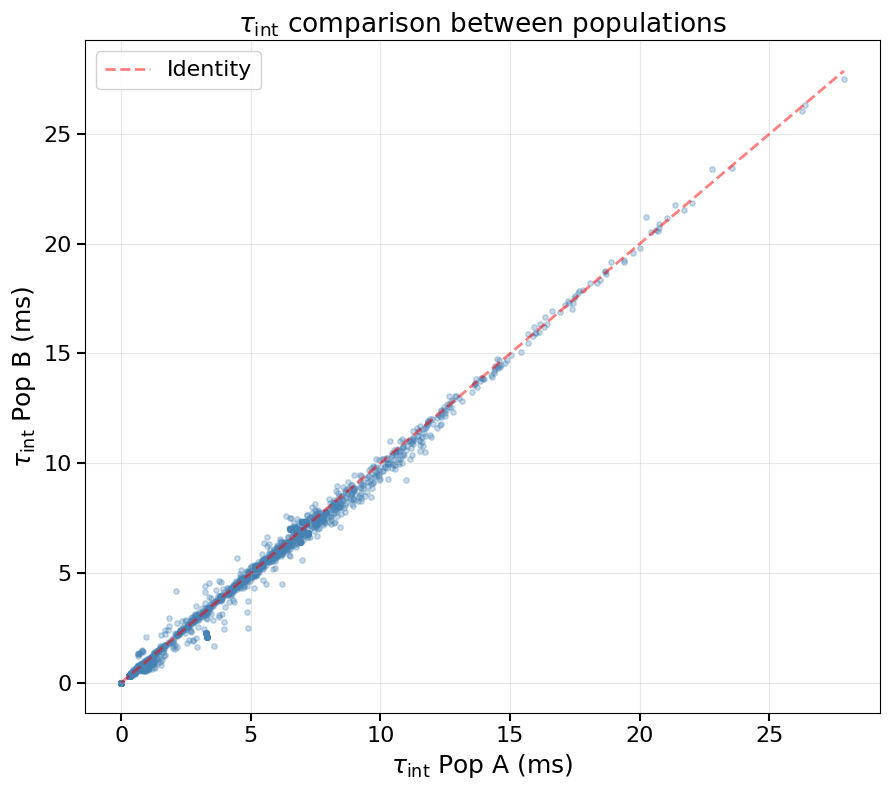

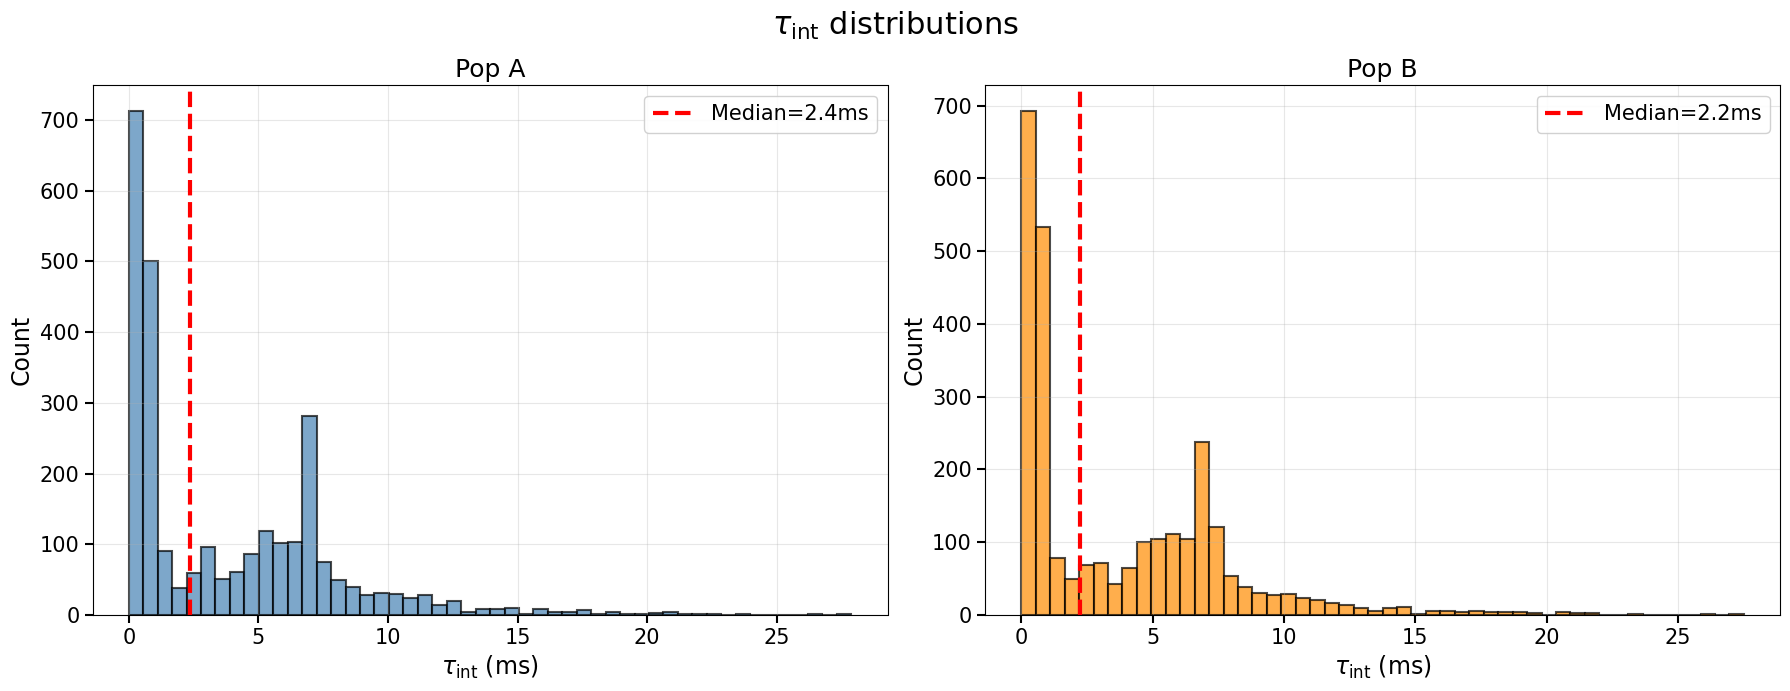

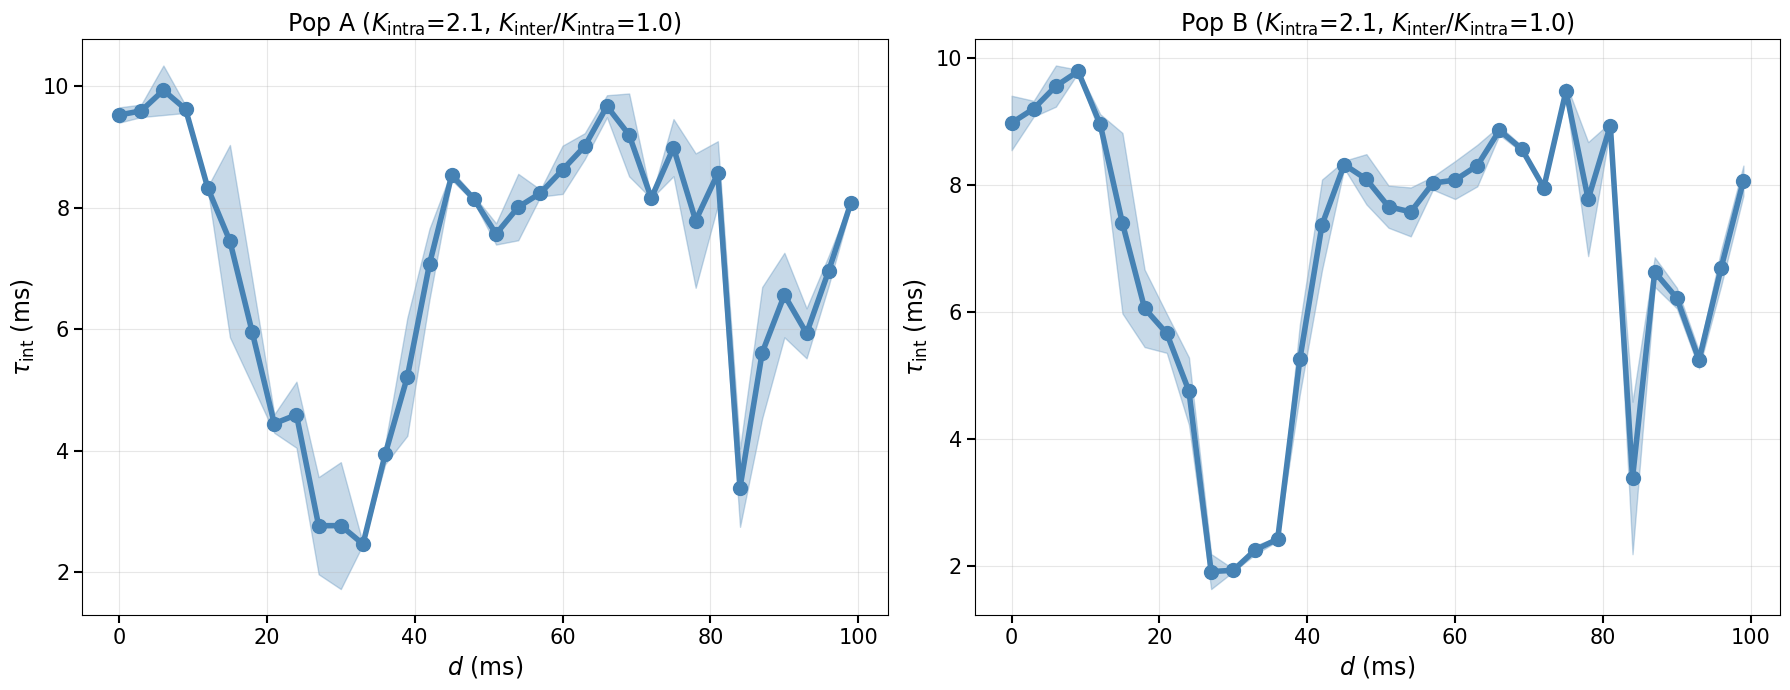

SUCCESS  | __main__:plot_final_dashboard:94 - Final dashboard completed


In [16]:
# Ejecutar dashboard existente
plot_final_dashboard(arrays_3d, sweep_dir)

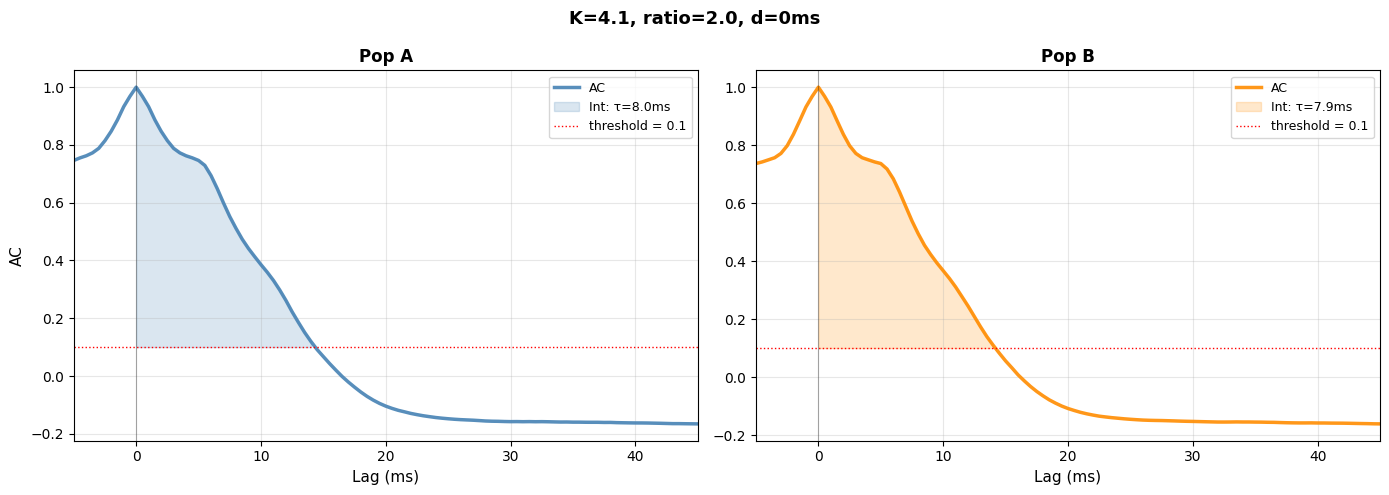

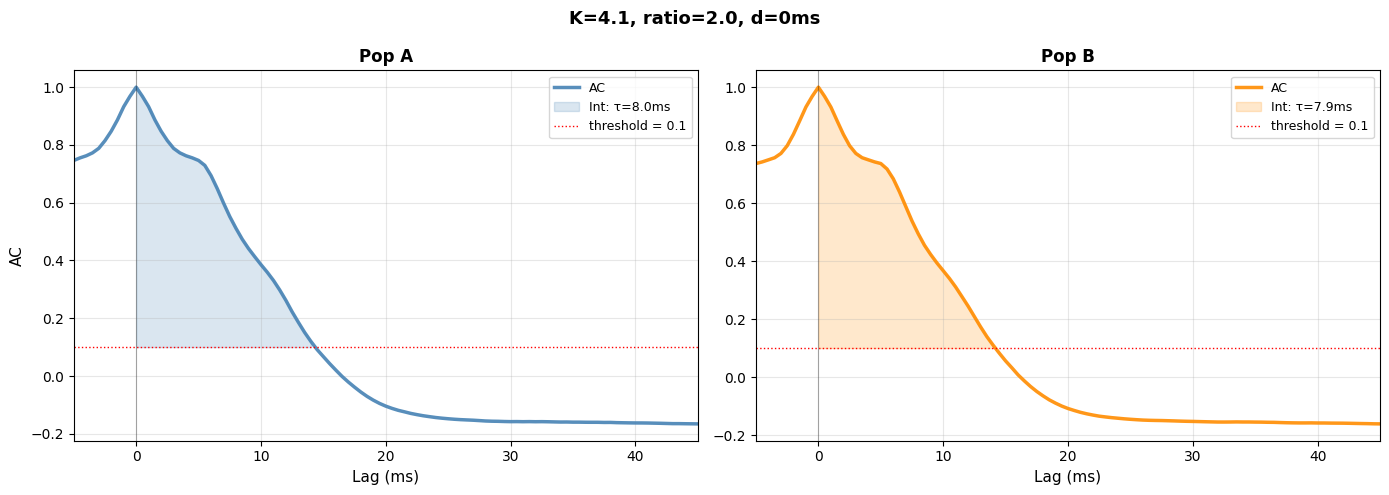

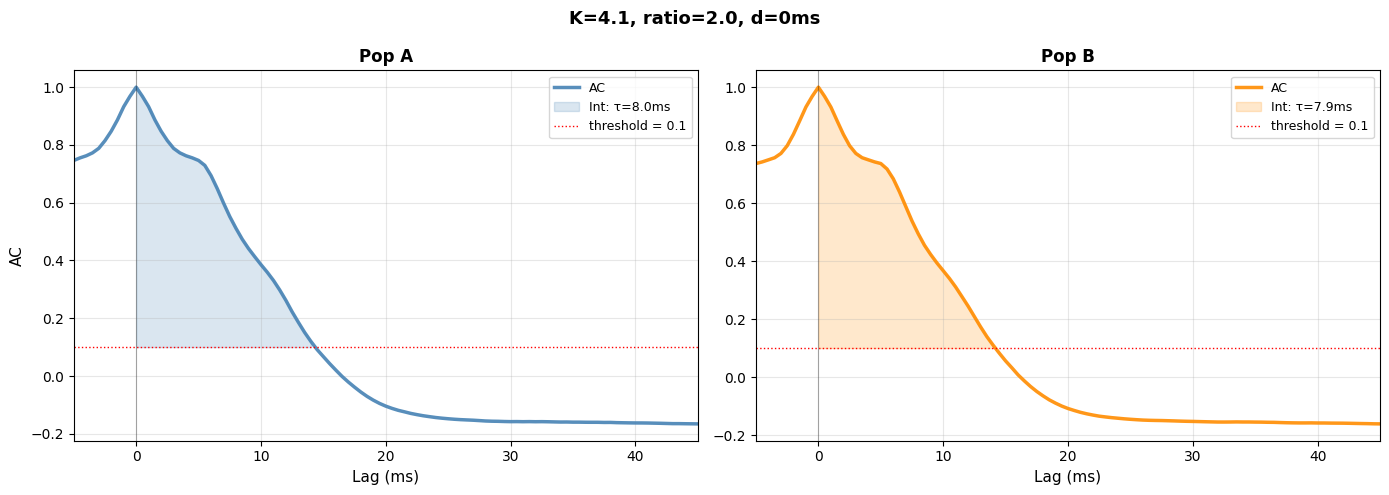

In [17]:
# Casos particulares
particular_cases = [
    {'k_intra': 4.1, 'k_inter_ratio': 2.0, 'delay': 0},
    {'k_intra': 4.1, 'k_inter_ratio': 2.0, 'delay': 0},
    {'k_intra': 4.1, 'k_inter_ratio':2.0, 'delay': 0}
]
plot_particular_cases_styled(sweep_dir, particular_cases)

In [24]:
arrays_3d.keys()

dict_keys(['ac_peak_A', 'mean_rate_B', 'tau_int_A_std', 'tau_int_B', 'tau_int_A', 'mean_rate_A', 'tau_int_B_std', 'ac_peak_B'])

In [ ]:
from src.two_populations.metrics import power_spectrum_analysis
from src.two_populations.plots.basic_plots import plot_spectral_detailed



power_spectrum_analysis(sweep_dir, overwrite=False)

In [19]:
# # 1. Verificar estructura de archivos
# import os
# output_dir = Path(f"./results/sweep_3d_autocorr_20251202_212148")

# print("📁 Archivos generados:")
# for subdir in ['raw_spikes', 'metrics_3d', 'plots_progress', 'casos_particulares']:
#     path = output_dir / subdir
#     if path.exists():
#         files = list(path.glob("*"))
#         print(f"  {subdir}/: {len(files)} archivos")

# # 2. Cargar y verificar arrays 3D
# arrays_3d, config = load_sweep_results(output_dir)

# print("\n📊 Arrays 3D:")
# for key in ['tau_int_A', 'tau_int_B']:
#     arr = arrays_3d[key]
#     valid = ~np.isnan(arr)
#     print(f"  {key}: {valid.sum()}/{arr.size} válidos, " +
#           f"rango [{np.nanmin(arr):.1f}, {np.nanmax(arr):.1f}] ms")

# # 3. Generar dashboard final
# #plot_final_dashboard(arrays_3d, output_dir)

# # 4. Analizar casos particulares
# particular_cases = [
#     {'k_intra': 2.0, 'k_inter_ratio': 0.0, 'delay': 0},
#     {'k_intra':  2.0, 'k_inter_ratio': 1.0, 'delay': 0},
#     {'k_intra': 2.0, 'k_inter_ratio': 2.0, 'delay': 0}
# ]
# plot_particular_cases_styled(output_dir, particular_cases)

In [20]:
# d = os.listdir("./results/")
# compare_sweeps([ds for ds in d if ds != 'logs'], labels = [ds for ds in d if ds != 'logs'])

In [21]:
# plot_optimal_region(arrays_3d, target_tau=10, tolerance=5)